# Импорт необходимых модулей и чтение датасета

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from scipy import stats

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool

import optuna
import shap
from tqdm import tqdm_notebook
from get_metrics import get_metrics_regression

RAND = 10

import warnings
warnings.filterwarnings("ignore")
from warnings import simplefilter
simplefilter("ignore", category=RuntimeWarning)

In [2]:
import pickle

with open('cat_cols.pkl', 'rb') as f:
    cat_cols = pickle.load(f)

In [3]:
df_train = pd.read_csv('df_train_preprod.csv')
df_test = pd.read_csv('df_test_preprod.csv')
SampleSubmission = pd.read_csv('SampleSubmission.csv')

In [4]:
# иначе lgbm ругается на названия столбцов
df_train = df_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
df_test = df_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [5]:
df_train.shape, df_test.shape

((8585, 220), (3680, 219))

In [6]:
# преобразование object признаков в category для lgbm
df_train[cat_cols] = df_train[cat_cols].astype('category')
df_test[cat_cols] = df_test[cat_cols].astype('category')

# Распределение целевой переменной

Распредление нормальное
pvalue = 0.9999999999999044


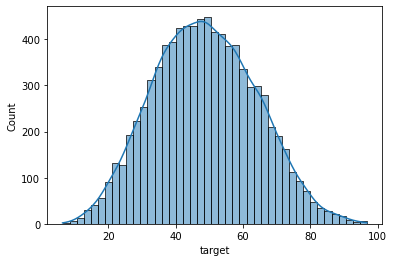

In [7]:
sns.histplot(df_train['target'], kde=True)

if stats.shapiro(df_train['target']).pvalue < 0.05 or stats.shapiro(df_train['target']).pvalue > 0.95:
    print('Распредление нормальное')
else:
    print('Распредление не нормальное')
    
print(f"pvalue = {1 - stats.shapiro(df_train['target']).pvalue}")

# логарифмирование не требуется

# train/test/val split

In [8]:
X_bin = pd.get_dummies(df_train.drop(columns=['target']))
X = df_train.drop(['target'], axis=1)
y = df_train['target']

X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                  test_size=0.2,
                                                  shuffle=True,
                                                  random_state=RAND)

X_train_bin, X_val_bin, y_train_bin, y_val_bin = train_test_split(X_bin,
                                                                  y,
                                                                  test_size=0.2,
                                                                  shuffle=True,
                                                                  random_state=RAND)

In [9]:
cor_matrix = X_train_bin.corr()

upper_tri = cor_matrix.where(
    np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))

to_drop = [
    column for column in upper_tri.columns if any(upper_tri[column] > 0.9)
]

In [10]:
X_train_bin = X_train_bin.drop(columns=to_drop)
X_val_bin = X_val_bin.drop(columns=to_drop)

# LinearRegression

In [11]:
lr = LinearRegression()
lr.fit(X_train_bin, y_train_bin)
y_pred = lr.predict(X_val_bin)

In [12]:
y_pred = lr.predict(X_val_bin)

metrics = get_metrics_regression(y_val_bin,
                                 y_pred,
                                 X_val_bin,
                                 name='LinearRegression')

metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,LinearRegression,9.034364,129.030237,11.359148,0.255625,0.327932,-7.442897,21.894283,18.563845


In [13]:
def check_overfitting(model, X_train, y_train, X_test, y_test):
    """
    Проверка на overfitting
    """
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    value_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    value_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

    print(f'RMSE train: %.3f' % value_train)
    print(f'RMSE test: %.3f' % value_test)
    print(f'delta = {(abs(value_train - value_test)/value_test*100):.1f} %')

In [14]:
check_overfitting(lr, X_train_bin, y_train_bin, X_val_bin, y_val_bin)

RMSE train: 11.214
RMSE test: 11.359
delta = 1.3 %


# XGBoost

## Baseline

In [15]:
xgb_base = XGBRegressor(random_state=RAND)
eval_set_bin = [(X_val_bin, y_val_bin)]

xgb_base.fit(X_train_bin,
             y_train_bin,
             eval_metric="rmse",
             eval_set=eval_set_bin,
             early_stopping_rounds=100,
             verbose=0);

In [16]:
y_pred = xgb_base.predict(X_val_bin)

metrics = metrics[:1]
metrics = metrics.append(get_metrics_regression(y_val_bin,
                                                y_pred,
                                                X_val_bin,
                                                name='XGBoost_baseine'))

metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,LinearRegression,9.034364,129.030237,11.359148,0.255625,0.327932,-7.442897,21.894283,18.563845
0,XGBoost_baseine,8.546609,115.341998,10.739739,0.241997,0.399229,-6.204059,20.494215,17.561605


In [17]:
check_overfitting(xgb_base, X_train_bin, y_train_bin, X_val_bin, y_val_bin)

RMSE train: 7.312
RMSE test: 10.740
delta = 31.9 %


## Tuning

In [29]:
def objective(trial, X, y, N_FOLDS, random_state):
    xgb_params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [574]),
        #"n_estimators": trial.suggest_int("n_estimators", 100, 1000, log=True),
        "learning_rate": trial.suggest_categorical("learning_rate", [0.022558922817870274]),
        #"learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 5, 10),
        "gamma": trial.suggest_int("gamma", 0, 20),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 1e2, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 1e2, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5,1.0),
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0.5, 1.0),
        "random_state": trial.suggest_categorical("random_state", [random_state])
    }

    cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=random_state)

    cv_predicts = np.empty(N_FOLDS)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # pruning_callback - Обратный вызов для XGBoost,
        # чтобы сократить бесперспективные испытания
        # observation_key - Оценочная метрика для обрезки
        pruning_callback = optuna.integration.XGBoostPruningCallback(
            trial, "validation_0-rmse")

        model = XGBRegressor(**xgb_params)
        model.fit(X_train,
                  y_train,
                  eval_set=[(X_val_bin, y_val_bin)],
                  eval_metric="rmse",
                  early_stopping_rounds=100,
                  callbacks=[pruning_callback],
                  verbose=0)

        preds = model.predict(X_test)
        cv_predicts[idx] = np.sqrt(mean_squared_error(y_test, preds))

    return np.mean(cv_predicts)

In [30]:
study = optuna.create_study(direction="minimize", study_name="XGB_01")
func = lambda trial: objective(
    trial, X_train_bin, y_train_bin, N_FOLDS=3, random_state=RAND)
study.optimize(func, n_trials=10, show_progress_bar=True, n_jobs=-1);

[I 2023-04-30 12:29:48,437] A new study created in memory with name: XGB_01


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-04-30 12:31:13,512] Trial 0 finished with value: 10.818473302036049 and parameters: {'n_estimators': 574, 'learning_rate': 0.022558922817870274, 'max_depth': 5, 'gamma': 17, 'reg_alpha': 0.07252857212396237, 'reg_lambda': 0.007032452662381735, 'subsample': 0.7445741445161, 'colsample_bytree': 0.9336879817781747, 'colsample_bylevel': 0.5745635451787934, 'colsample_bynode': 0.5451105874953522, 'random_state': 10}. Best is trial 0 with value: 10.818473302036049.
[I 2023-04-30 12:31:15,527] Trial 2 finished with value: 10.828710436724515 and parameters: {'n_estimators': 574, 'learning_rate': 0.022558922817870274, 'max_depth': 5, 'gamma': 2, 'reg_alpha': 0.0010454664228484627, 'reg_lambda': 0.591375568030248, 'subsample': 0.7047539380792629, 'colsample_bytree': 0.717077165293152, 'colsample_bylevel': 0.5528214018772277, 'colsample_bynode': 0.6350928358055289, 'random_state': 10}. Best is trial 0 with value: 10.818473302036049.
[I 2023-04-30 12:31:41,251] Trial 1 finished with value:

In [31]:
print(f"\tBest value (rmse): {study.best_value:.5f}")
print(f"\tBest params:")
 
for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (rmse): 10.76490
	Best params:
		n_estimators: 574
		learning_rate: 0.022558922817870274
		max_depth: 6
		gamma: 11
		reg_alpha: 0.009255488119535638
		reg_lambda: 0.0034284602130240653
		subsample: 0.7744991141095803
		colsample_bytree: 0.5693158948337296
		colsample_bylevel: 0.8329251960421915
		colsample_bynode: 0.5434186345506401
		random_state: 10


In [32]:
xgb_tuned = XGBRegressor(**study.best_params)

xgb_tuned.fit(X_train_bin,
                  y_train_bin,
                  eval_set=eval_set_bin,
                  eval_metric='rmse',
                  early_stopping_rounds=100,
                  verbose=0);

In [33]:
y_pred = xgb_tuned.predict(X_val_bin)

metrics = metrics[:2]
metrics = metrics.append(
    get_metrics_regression(y_test=y_val_bin,
                           y_pred=y_pred,
                           X_test=X_val_bin,
                           name='XGBoost_optuna'))

metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,LinearRegression,9.034364,129.030237,11.359148,0.255625,0.327932,-7.442897,21.894283,18.563845
0,XGBoost_baseine,8.546609,115.341998,10.739739,0.241997,0.399229,-6.204059,20.494215,17.561605
0,XGBoost_optuna,8.330275,110.252161,10.500103,0.237475,0.425740,-6.661616,20.144135,17.117081


In [34]:
check_overfitting(xgb_tuned, X_train_bin, y_train_bin, X_val_bin, y_val_bin)

RMSE train: 7.774
RMSE test: 10.500
delta = 26.0 %


Получилось улучшить целевую метрику и снизить переобучение

# LightGBM

## Baseline

In [35]:
lgbm_base = LGBMRegressor(random_state=RAND)
eval_set = [(X_val, y_val)]

lgbm_base.fit(X_train,
        y_train,
        eval_metric="rmse",
        eval_set=eval_set,
        early_stopping_rounds=100,
        verbose=0);

In [36]:
y_pred = lgbm_base.predict(X_val)

metrics = metrics[:3]
metrics = metrics.append(get_metrics_regression(y_val,
                                                y_pred,
                                                X_val,
                                                name='LightGBM_baseine'))

metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,LinearRegression,9.034364,129.030237,11.359148,0.255625,0.327932,-7.442897,21.894283,18.563845
0,XGBoost_baseine,8.546609,115.341998,10.739739,0.241997,0.399229,-6.204059,20.494215,17.561605
0,XGBoost_optuna,8.330275,110.252161,10.500103,0.237475,0.425740,-6.661616,20.144135,17.117081
0,LightGBM_baseine,8.324838,110.285172,10.501675,0.238927,0.436312,-6.730508,20.214539,17.105908


In [37]:
check_overfitting(lgbm_base,
                  X_train,
                  y_train,
                  X_val,
                  y_val)

RMSE train: 7.887
RMSE test: 10.502
delta = 24.9 %


## Tuning

In [38]:
# n_estimators: 848 learning_rate: 0.01381679192733079
def objective_lgb(trial, X, y, N_FOLDS, random_state=10):
    lgb_params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [848]),
        #"n_estimators": trial.suggest_int("n_estimators", 100, 1000, log=True),
        "learning_rate": trial.suggest_categorical("learning_rate", [0.013861718741189964]),
        #"learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 500, step=10),
        "max_depth": trial.suggest_int("max_depth", 3, 9),
        "max_bin": trial.suggest_int("max_bin", 50, 300),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 100, step=3),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 20.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
        "random_state": trial.suggest_categorical("random_state", [random_state])}

    N_FOLDS = 3
    cv = KFold(n_splits=N_FOLDS, shuffle=True)

    cv_predicts = np.empty(N_FOLDS)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pruning_callback = optuna.integration.LightGBMPruningCallback(
            trial, "l2")
        model = LGBMRegressor(**lgb_params)
        model.fit(X_train,
                  y_train,
                  eval_set=[(X_val, y_val)],
                  eval_metric="rmse",
                  early_stopping_rounds=100,
                  callbacks=[pruning_callback],
                  verbose=0)

        preds = model.predict(X_test)
        cv_predicts[idx] = np.sqrt(mean_squared_error(y_test, preds))

    return np.mean(cv_predicts)

In [75]:
study = optuna.create_study(direction="minimize", study_name="LGB_1")
func = lambda trial: objective_lgb(trial, X_train, y_train, N_FOLDS=3, random_state=RAND)
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(func, n_trials=10, show_progress_bar=True)

  0%|          | 0/10 [00:00<?, ?it/s]

In [76]:
print(f"\tBest value (RMSE): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (RMSE): 10.64101
	Best params:
		n_estimators: 848
		learning_rate: 0.013861718741189964
		num_leaves: 290
		max_depth: 6
		max_bin: 162
		min_child_samples: 40
		reg_alpha: 9.650689647241249
		reg_lambda: 0.1515168075182999
		subsample: 0.5527156212331009
		colsample_bytree: 0.42415393018354297
		random_state: 10


In [77]:
lgb_tuned = LGBMRegressor(**study.best_params)
lgb_tuned.fit(X_train,
             y_train,
             eval_metric="rmse",
             eval_set=eval_set,
             verbose=False,
             early_stopping_rounds=100)

metrics = metrics[:4]
y_pred = lgb_tuned.predict(X_val)
metrics = metrics.append(get_metrics_regression(y_val,
                                                y_pred,
                                                X_val,
                                                name='LightGBM_optuna'))

metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,LinearRegression,9.034364,129.030237,11.359148,0.255625,0.327932,-7.442897,21.894283,18.563845
0,XGBoost_baseine,8.546609,115.341998,10.739739,0.241997,0.399229,-6.204059,20.494215,17.561605
0,XGBoost_optuna,8.330275,110.252161,10.500103,0.237475,0.425740,-6.661616,20.144135,17.117081
0,LightGBM_baseine,8.324838,110.285172,10.501675,0.238927,0.436312,-6.730508,20.214539,17.105908
0,LightGBM_optuna,8.248749,107.709408,10.378314,0.235859,0.449477,-6.694280,19.974160,16.949561


In [78]:
check_overfitting(lgb_tuned, X_train, y_train, X_val, y_val)

RMSE train: 8.004
RMSE test: 10.378
delta = 22.9 %


Переобучение уменьшилось, метрика немного улучшилась

# Catboost

## Baseline

In [79]:
cat_cols = [x for x in cat_cols if x in X.columns]

cat_base = CatBoostRegressor(random_state=RAND, eval_metric="RMSE", cat_features = cat_cols)

cat_base.fit(X_train,
            y_train,
            eval_set=eval_set,
            early_stopping_rounds=100,
            verbose=0); 

In [80]:
y_pred = cat_base.predict(X_val)

metrics = metrics.append(get_metrics_regression(y_val,
                                                y_pred,
                                                X_val,
                                                name='CatBoost_baseine'))

metrics 

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,LinearRegression,9.034364,129.030237,11.359148,0.255625,0.327932,-7.442897,21.894283,18.563845
0,XGBoost_baseine,8.546609,115.341998,10.739739,0.241997,0.399229,-6.204059,20.494215,17.561605
0,XGBoost_optuna,8.330275,110.252161,10.500103,0.237475,0.425740,-6.661616,20.144135,17.117081
0,LightGBM_baseine,8.324838,110.285172,10.501675,0.238927,0.436312,-6.730508,20.214539,17.105908
0,LightGBM_optuna,8.248749,107.709408,10.378314,0.235859,0.449477,-6.694280,19.974160,16.949561
0,CatBoost_baseine,8.328458,109.616990,10.469813,0.239231,0.439727,-7.005991,20.272736,17.113346


In [81]:
check_overfitting(cat_base, X_train, y_train, X_val, y_val)

RMSE train: 8.316
RMSE test: 10.470
delta = 20.6 %


## Tuning

In [82]:
# целевая функция
# n_estimators: 1064, learning_rate: 0.09227982701978373
def objective_cb(trial, X, y, N_FOLDS, random_state):
    params = {
        #"n_estimators": trial.suggest_int("n_estimators", 100, 2000, log=True),
        "n_estimators": trial.suggest_categorical("n_estimators", [1164]),
        #"learning_rate": trial.suggest_float("learning_rate", 0.0001, 0.1, log=True),
        "learning_rate": trial.suggest_categorical("learning_rate", [0.081227982701978373]),
        
        "max_depth": trial.suggest_int("max_depth", 6, 10),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5,1.0),
        "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 1e-3, 1e2),
        'od_wait': trial.suggest_int('od_wait', 500, 2000),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations', 1, 15),
        "loss_function": trial.suggest_categorical("loss_function", ["RMSE"]),
        "eval_metric": trial.suggest_categorical("eval_metric", ["RMSE"]),
        "random_state": random_state}

    cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND)

    cv_predicts = np.empty(N_FOLDS)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        train_data = Pool(data=X_train, label=y_train, cat_features = cat_cols)
        eval_data = Pool(data=X_test, label=y_test, cat_features = cat_cols)

        model = CatBoostRegressor(**params, cat_features = cat_cols)
        model.fit(train_data,
                  eval_set=eval_data,
                  early_stopping_rounds=100,
                  verbose=0)

        preds = model.predict(X_test)
        cv_predicts[idx] = np.sqrt(mean_squared_error(y_test, preds))

    return np.mean(cv_predicts)

In [111]:
study_cat = optuna.create_study(
    direction="minimize",
    pruner=optuna.pruners.SuccessiveHalvingPruner(),
    study_name="Cat_02")


def func(trial): return objective_cb(trial,
                                     X_train,
                                     y_train,
                                     N_FOLDS=3,
                                     random_state=RAND)


study_cat.optimize(func, n_trials=10, show_progress_bar=True)

  0%|          | 0/10 [00:00<?, ?it/s]

In [112]:
print(f"\tBest value (MAE): {study_cat.best_value:.5f}")
print(f"\tBest params:")

for key, value in study_cat.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (MAE): 10.64605
	Best params:
		n_estimators: 1164
		learning_rate: 0.08122798270197837
		max_depth: 6
		colsample_bylevel: 0.6828023700928709
		l2_leaf_reg: 33.99662028096278
		od_wait: 635
		leaf_estimation_iterations: 3
		loss_function: RMSE
		eval_metric: RMSE


In [113]:
cat_tuned = CatBoostRegressor(**study_cat.best_params, cat_features = cat_cols)
cat_tuned.fit(X_train,
               y_train,
               eval_set=eval_set,
               verbose=False,
               early_stopping_rounds=100)

y_pred = cat_tuned.predict(X_val)

metrics = metrics[:6]
metrics = metrics.append(
    get_metrics_regression(y_test=y_val,
                           y_pred=y_pred,
                           X_test=X_val,
                           name='CatBoost_Optuna'))

metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,LinearRegression,9.034364,129.030237,11.359148,0.255625,0.327932,-7.442897,21.894283,18.563845
0,XGBoost_baseine,8.546609,115.341998,10.739739,0.241997,0.399229,-6.204059,20.494215,17.561605
0,XGBoost_optuna,8.330275,110.252161,10.500103,0.237475,0.425740,-6.661616,20.144135,17.117081
0,LightGBM_baseine,8.324838,110.285172,10.501675,0.238927,0.436312,-6.730508,20.214539,17.105908
0,LightGBM_optuna,8.248749,107.709408,10.378314,0.235859,0.449477,-6.694280,19.974160,16.949561
0,CatBoost_baseine,8.328458,109.616990,10.469813,0.239231,0.439727,-7.005991,20.272736,17.113346
0,CatBoost_Optuna,8.274076,107.989794,10.391814,0.236540,0.448044,-6.427737,19.997323,17.001602


In [114]:
check_overfitting(cat_tuned, X_train, y_train, X_val, y_val)

RMSE train: 8.233
RMSE test: 10.392
delta = 20.8 %


Переобучение уменьшить не получилось, но метрики улучшились

# Best model feature importance

Лучше всего себя показали тюненые модели LGBM и CatBoost

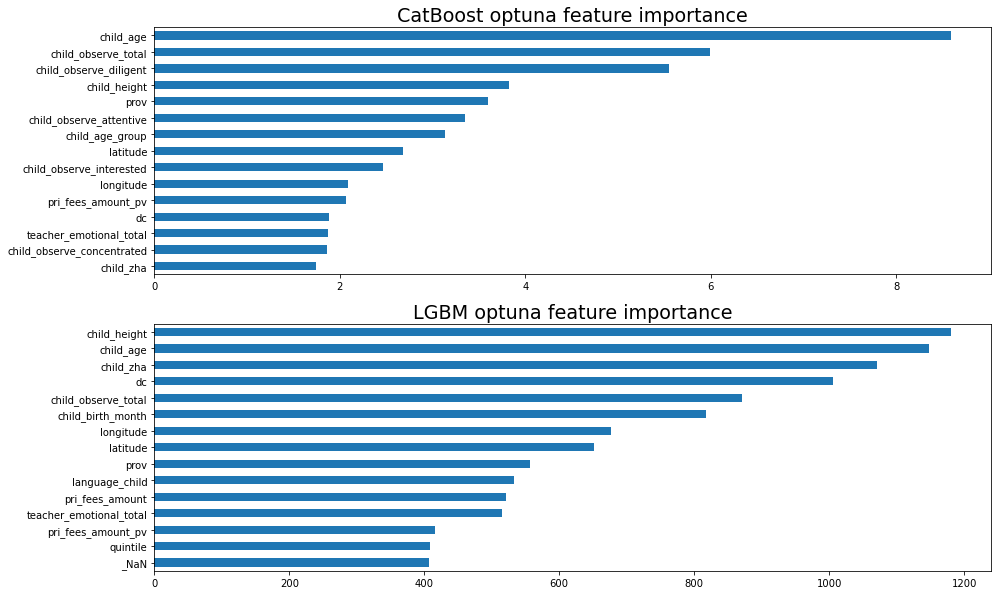

In [115]:
fig, ax = plt.subplots(nrows=2, figsize=(15, 30))
plt.rcParams.update({'font.size': 16})

feature_imp_cat = pd.Series(cat_tuned.feature_importances_, index=X.columns)
feature_imp_cat.nlargest(15).sort_values(ascending=True).plot(kind='barh', figsize=(15, 10), ax=ax[0])
ax[0].set_title('CatBoost optuna feature importance')

feature_imp_cat = pd.Series(lgb_tuned.feature_importances_, index=X.columns)
feature_imp_cat.nlargest(15).sort_values(ascending=True).plot(kind='barh', figsize=(15, 10), ax=ax[1])
ax[1].set_title('LGBM optuna feature importance');

# Стекинг

In [116]:
from sklearn.base import BaseEstimator, RegressorMixin


class Stacking(BaseEstimator, RegressorMixin):
    def __init__(self, models, ens_model, cat_cols, cv: int = 3, err: int = 0.001):
        """
        models - базовые модели для стекинга
        ens_model - мета-модель
        cv - кол-во фолдов
        err - величина случайной добавки к метапризнакам
        cat_cols - список категориальных столбцов
        """
        self.models = models
        self.ens_model = ens_model
        self.cv = cv
        self.err = err
        self.cat_cols = cat_cols
        
    def crossval_predict(self, model, X: pd.DataFrame, 
                         y: pd.Series) -> np.array:
        """
        Получение новых мета-признаков при помощи кросс-валидации
        """
        folds = KFold(n_splits=self.cv)
        predicts = []

        for fold, (train_index, test_index) in enumerate(folds.split(X, y)):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
 
            if model.__class__.__name__ == 'LGBMRegressor':
                model.fit(X_train,
                          y_train,
                          eval_metric="rmse",
                          eval_set=[(X_test, y_test)],
                          verbose=False,
                          early_stopping_rounds=100)
            elif model.__class__.__name__ == 'CatBoostRegressor':
                train_data = Pool(data=X_train,
                                  label=y_train,
                                  cat_features=self.cat_cols)
                model.fit(X_train,
                          y_train,
                          eval_metric="rmse",
                          eval_set=[(X_test, y_test)],
                          use_best_model=True, 
                          verbose=False,
                          early_stopping_rounds=100)
                          
            elif model.__class__.__name__ == 'XGBRegressor':
                model.fit(X_train,
                          y_train,
                          eval_metric="rmse",
                          eval_set=[(X_test, y_test)],
                          verbose=False,
                          early_stopping_rounds=100)
            else: 
                model.fit(X_train, y_train)
                
            y_pred = model.predict(pd.get_dummies(X_test))
            predicts.append(y_pred)
            
        return np.concatenate(predicts)


    def fit(self, X: pd.DataFrame, y: pd.Series, X_bin: pd.DataFrame):
        """
        Обучение ансамбля моделей
        """
        meta_X = self.err*np.random.randn(X.shape[0], len(models))

        
        for n, model in enumerate(self.models):
            # обучение на категориальных данных
            if model.__class__.__name__ in ['LGBMRegressor', 'CatBoostRegressor']:
                
                meta_X[:, n] += cross_val_predict(model, X=X, y=y, cv=self.cv)
                # настройка модели для предсказания на test
                if model.__class__.__name__ == 'CatBoostRegressor':
                    model.fit(X, y, cat_features=self.cat_cols, silent=True)
                else:
                    model.fit(X, y, verbose=False)
            # обучение на бинаризованных данных
            else:
                meta_X[:, n] += cross_val_predict(model, X=X_bin, y=y, cv=self.cv)
                # настройка модели для предсказания на test
                model.fit(X_bin, y)
    
        self.ens_model.fit(meta_X, y)

        return self

    def predict(self, X: pd.DataFrame, X_bin: pd.DataFrame) -> np.array:
        """
        Получение прогнозов на test
        """
        meta_X = np.zeros((X.shape[0], len(models)))

        for n, model in enumerate(self.models):
            if model.__class__.__name__ in ['LGBMRegressor', 'CatBoostRegressor']:
            # ответы на тестовой выборке
                meta_X[:, n] = model.predict(X)
            else:
                meta_X[:, n] = model.predict(X_bin)
                
        return self.ens_model.predict(meta_X)

In [178]:
models = [Ridge(alpha=1000),
          xgb_tuned, 
          lgb_tuned,
          cat_base,
          cat_tuned] 

stack_model = Ridge(alpha=10)
stack = Stacking(models, stack_model, cat_cols, cv=3, err = -0.4)
stack.fit(X_train, y_train, X_train_bin)

Learning rate set to 0.052067
0:	learn: 14.8188126	total: 38.1ms	remaining: 38s
1:	learn: 14.6023511	total: 78.5ms	remaining: 39.2s
2:	learn: 14.3970484	total: 122ms	remaining: 40.5s
3:	learn: 14.1937166	total: 163ms	remaining: 40.5s
4:	learn: 14.0259287	total: 214ms	remaining: 42.7s
5:	learn: 13.8651003	total: 262ms	remaining: 43.3s
6:	learn: 13.6990122	total: 306ms	remaining: 43.4s
7:	learn: 13.5460172	total: 348ms	remaining: 43.1s
8:	learn: 13.4137458	total: 391ms	remaining: 43s
9:	learn: 13.2841575	total: 435ms	remaining: 43.1s
10:	learn: 13.1643089	total: 481ms	remaining: 43.3s
11:	learn: 13.0434056	total: 525ms	remaining: 43.2s
12:	learn: 12.9282253	total: 566ms	remaining: 43s
13:	learn: 12.8212770	total: 606ms	remaining: 42.7s
14:	learn: 12.7336620	total: 650ms	remaining: 42.7s
15:	learn: 12.6519043	total: 700ms	remaining: 43s
16:	learn: 12.5628412	total: 751ms	remaining: 43.4s
17:	learn: 12.4819557	total: 797ms	remaining: 43.5s
18:	learn: 12.4077898	total: 838ms	remaining: 43.3

159:	learn: 10.1418519	total: 7.25s	remaining: 38.1s
160:	learn: 10.1290917	total: 7.3s	remaining: 38s
161:	learn: 10.1250413	total: 7.35s	remaining: 38s
162:	learn: 10.1229030	total: 7.4s	remaining: 38s
163:	learn: 10.1168826	total: 7.45s	remaining: 38s
164:	learn: 10.1071612	total: 7.49s	remaining: 37.9s
165:	learn: 10.0969020	total: 7.54s	remaining: 37.9s
166:	learn: 10.0872455	total: 7.58s	remaining: 37.8s
167:	learn: 10.0828305	total: 7.62s	remaining: 37.8s
168:	learn: 10.0772701	total: 7.67s	remaining: 37.7s
169:	learn: 10.0713623	total: 7.71s	remaining: 37.6s
170:	learn: 10.0659010	total: 7.76s	remaining: 37.6s
171:	learn: 10.0596131	total: 7.8s	remaining: 37.6s
172:	learn: 10.0482306	total: 7.84s	remaining: 37.5s
173:	learn: 10.0434842	total: 7.89s	remaining: 37.4s
174:	learn: 10.0375752	total: 7.93s	remaining: 37.4s
175:	learn: 10.0281241	total: 7.97s	remaining: 37.3s
176:	learn: 10.0232757	total: 8.02s	remaining: 37.3s
177:	learn: 10.0197935	total: 8.08s	remaining: 37.3s
178:

321:	learn: 9.3106238	total: 14.7s	remaining: 31s
322:	learn: 9.3089510	total: 14.8s	remaining: 31s
323:	learn: 9.3031995	total: 14.8s	remaining: 30.9s
324:	learn: 9.2974389	total: 14.9s	remaining: 30.9s
325:	learn: 9.2929113	total: 14.9s	remaining: 30.8s
326:	learn: 9.2900684	total: 14.9s	remaining: 30.8s
327:	learn: 9.2824306	total: 15s	remaining: 30.7s
328:	learn: 9.2796411	total: 15s	remaining: 30.7s
329:	learn: 9.2726624	total: 15.1s	remaining: 30.7s
330:	learn: 9.2696243	total: 15.2s	remaining: 30.6s
331:	learn: 9.2614205	total: 15.2s	remaining: 30.6s
332:	learn: 9.2576831	total: 15.3s	remaining: 30.6s
333:	learn: 9.2474357	total: 15.3s	remaining: 30.6s
334:	learn: 9.2397384	total: 15.4s	remaining: 30.5s
335:	learn: 9.2390838	total: 15.4s	remaining: 30.5s
336:	learn: 9.2359639	total: 15.5s	remaining: 30.5s
337:	learn: 9.2351251	total: 15.5s	remaining: 30.4s
338:	learn: 9.2302111	total: 15.6s	remaining: 30.4s
339:	learn: 9.2290470	total: 15.6s	remaining: 30.3s
340:	learn: 9.221924

480:	learn: 8.7416334	total: 22.1s	remaining: 23.9s
481:	learn: 8.7370826	total: 22.2s	remaining: 23.8s
482:	learn: 8.7337553	total: 22.2s	remaining: 23.8s
483:	learn: 8.7307744	total: 22.2s	remaining: 23.7s
484:	learn: 8.7300705	total: 22.3s	remaining: 23.7s
485:	learn: 8.7279443	total: 22.3s	remaining: 23.6s
486:	learn: 8.7210991	total: 22.4s	remaining: 23.6s
487:	learn: 8.7168104	total: 22.4s	remaining: 23.5s
488:	learn: 8.7146820	total: 22.5s	remaining: 23.5s
489:	learn: 8.7106185	total: 22.5s	remaining: 23.4s
490:	learn: 8.7052563	total: 22.6s	remaining: 23.4s
491:	learn: 8.7021302	total: 22.6s	remaining: 23.4s
492:	learn: 8.6971016	total: 22.7s	remaining: 23.3s
493:	learn: 8.6955205	total: 22.7s	remaining: 23.3s
494:	learn: 8.6934433	total: 22.8s	remaining: 23.2s
495:	learn: 8.6912802	total: 22.8s	remaining: 23.2s
496:	learn: 8.6844889	total: 22.9s	remaining: 23.2s
497:	learn: 8.6812754	total: 22.9s	remaining: 23.1s
498:	learn: 8.6783731	total: 23s	remaining: 23.1s
499:	learn: 8.

640:	learn: 8.3052289	total: 29.7s	remaining: 16.6s
641:	learn: 8.3042946	total: 29.8s	remaining: 16.6s
642:	learn: 8.3022462	total: 29.8s	remaining: 16.5s
643:	learn: 8.2981279	total: 29.9s	remaining: 16.5s
644:	learn: 8.2976311	total: 29.9s	remaining: 16.5s
645:	learn: 8.2976097	total: 29.9s	remaining: 16.4s
646:	learn: 8.2939543	total: 30s	remaining: 16.4s
647:	learn: 8.2929699	total: 30s	remaining: 16.3s
648:	learn: 8.2904498	total: 30.1s	remaining: 16.3s
649:	learn: 8.2889635	total: 30.1s	remaining: 16.2s
650:	learn: 8.2854599	total: 30.2s	remaining: 16.2s
651:	learn: 8.2854128	total: 30.2s	remaining: 16.1s
652:	learn: 8.2848706	total: 30.3s	remaining: 16.1s
653:	learn: 8.2804097	total: 30.3s	remaining: 16s
654:	learn: 8.2795467	total: 30.4s	remaining: 16s
655:	learn: 8.2750994	total: 30.4s	remaining: 15.9s
656:	learn: 8.2708681	total: 30.4s	remaining: 15.9s
657:	learn: 8.2679081	total: 30.5s	remaining: 15.8s
658:	learn: 8.2642440	total: 30.5s	remaining: 15.8s
659:	learn: 8.261046

801:	learn: 7.9620188	total: 37.3s	remaining: 9.21s
802:	learn: 7.9593803	total: 37.3s	remaining: 9.16s
803:	learn: 7.9565551	total: 37.4s	remaining: 9.11s
804:	learn: 7.9548899	total: 37.4s	remaining: 9.07s
805:	learn: 7.9539344	total: 37.5s	remaining: 9.02s
806:	learn: 7.9503861	total: 37.5s	remaining: 8.97s
807:	learn: 7.9496119	total: 37.6s	remaining: 8.93s
808:	learn: 7.9487291	total: 37.6s	remaining: 8.88s
809:	learn: 7.9461785	total: 37.6s	remaining: 8.83s
810:	learn: 7.9448364	total: 37.7s	remaining: 8.78s
811:	learn: 7.9421274	total: 37.7s	remaining: 8.74s
812:	learn: 7.9420923	total: 37.8s	remaining: 8.69s
813:	learn: 7.9393127	total: 37.8s	remaining: 8.64s
814:	learn: 7.9378069	total: 37.9s	remaining: 8.6s
815:	learn: 7.9356304	total: 37.9s	remaining: 8.55s
816:	learn: 7.9303863	total: 38s	remaining: 8.5s
817:	learn: 7.9302727	total: 38s	remaining: 8.46s
818:	learn: 7.9288188	total: 38.1s	remaining: 8.41s
819:	learn: 7.9266449	total: 38.1s	remaining: 8.37s
820:	learn: 7.9214

960:	learn: 7.6549375	total: 44.7s	remaining: 1.81s
961:	learn: 7.6501965	total: 44.7s	remaining: 1.76s
962:	learn: 7.6483880	total: 44.7s	remaining: 1.72s
963:	learn: 7.6480628	total: 44.8s	remaining: 1.67s
964:	learn: 7.6466352	total: 44.8s	remaining: 1.63s
965:	learn: 7.6449968	total: 44.9s	remaining: 1.58s
966:	learn: 7.6421324	total: 44.9s	remaining: 1.53s
967:	learn: 7.6402144	total: 45s	remaining: 1.49s
968:	learn: 7.6373190	total: 45s	remaining: 1.44s
969:	learn: 7.6335929	total: 45.1s	remaining: 1.39s
970:	learn: 7.6307523	total: 45.1s	remaining: 1.35s
971:	learn: 7.6303101	total: 45.2s	remaining: 1.3s
972:	learn: 7.6297374	total: 45.2s	remaining: 1.25s
973:	learn: 7.6284346	total: 45.3s	remaining: 1.21s
974:	learn: 7.6264971	total: 45.3s	remaining: 1.16s
975:	learn: 7.6248177	total: 45.3s	remaining: 1.11s
976:	learn: 7.6242748	total: 45.4s	remaining: 1.07s
977:	learn: 7.6230095	total: 45.4s	remaining: 1.02s
978:	learn: 7.6185180	total: 45.5s	remaining: 976ms
979:	learn: 7.617

122:	learn: 10.6208781	total: 5.56s	remaining: 39.7s
123:	learn: 10.6123488	total: 5.6s	remaining: 39.6s
124:	learn: 10.6047810	total: 5.64s	remaining: 39.5s
125:	learn: 10.5972355	total: 5.68s	remaining: 39.4s
126:	learn: 10.5954366	total: 5.73s	remaining: 39.4s
127:	learn: 10.5882623	total: 5.78s	remaining: 39.3s
128:	learn: 10.5829720	total: 5.82s	remaining: 39.3s
129:	learn: 10.5716991	total: 5.87s	remaining: 39.3s
130:	learn: 10.5669722	total: 5.92s	remaining: 39.2s
131:	learn: 10.5600266	total: 5.96s	remaining: 39.2s
132:	learn: 10.5470821	total: 6.02s	remaining: 39.3s
133:	learn: 10.5387294	total: 6.07s	remaining: 39.2s
134:	learn: 10.5333272	total: 6.11s	remaining: 39.1s
135:	learn: 10.5262818	total: 6.15s	remaining: 39.1s
136:	learn: 10.5219611	total: 6.19s	remaining: 39s
137:	learn: 10.5164680	total: 6.23s	remaining: 38.9s
138:	learn: 10.5069586	total: 6.28s	remaining: 38.9s
139:	learn: 10.5023334	total: 6.32s	remaining: 38.8s
140:	learn: 10.4965259	total: 6.36s	remaining: 38

283:	learn: 9.5961100	total: 13.3s	remaining: 33.4s
284:	learn: 9.5950144	total: 13.3s	remaining: 33.4s
285:	learn: 9.5938961	total: 13.4s	remaining: 33.3s
286:	learn: 9.5931483	total: 13.4s	remaining: 33.3s
287:	learn: 9.5839322	total: 13.4s	remaining: 33.2s
288:	learn: 9.5829543	total: 13.5s	remaining: 33.2s
289:	learn: 9.5748481	total: 13.5s	remaining: 33.1s
290:	learn: 9.5680388	total: 13.6s	remaining: 33.1s
291:	learn: 9.5676600	total: 13.6s	remaining: 33s
292:	learn: 9.5639033	total: 13.7s	remaining: 33s
293:	learn: 9.5592432	total: 13.7s	remaining: 32.9s
294:	learn: 9.5525874	total: 13.8s	remaining: 32.9s
295:	learn: 9.5518766	total: 13.8s	remaining: 32.9s
296:	learn: 9.5487074	total: 13.9s	remaining: 32.8s
297:	learn: 9.5440184	total: 13.9s	remaining: 32.8s
298:	learn: 9.5435283	total: 14s	remaining: 32.7s
299:	learn: 9.5420181	total: 14s	remaining: 32.7s
300:	learn: 9.5335630	total: 14s	remaining: 32.6s
301:	learn: 9.5275182	total: 14.1s	remaining: 32.6s
302:	learn: 9.5204802	

442:	learn: 9.0479237	total: 20.6s	remaining: 25.9s
443:	learn: 9.0462040	total: 20.6s	remaining: 25.9s
444:	learn: 9.0447112	total: 20.7s	remaining: 25.8s
445:	learn: 9.0418764	total: 20.7s	remaining: 25.8s
446:	learn: 9.0369239	total: 20.8s	remaining: 25.7s
447:	learn: 9.0353348	total: 20.8s	remaining: 25.7s
448:	learn: 9.0279225	total: 20.9s	remaining: 25.6s
449:	learn: 9.0239121	total: 20.9s	remaining: 25.6s
450:	learn: 9.0195240	total: 21s	remaining: 25.5s
451:	learn: 9.0163303	total: 21s	remaining: 25.5s
452:	learn: 9.0116680	total: 21.1s	remaining: 25.4s
453:	learn: 9.0111350	total: 21.1s	remaining: 25.4s
454:	learn: 9.0041456	total: 21.1s	remaining: 25.3s
455:	learn: 8.9951619	total: 21.2s	remaining: 25.3s
456:	learn: 8.9897002	total: 21.2s	remaining: 25.2s
457:	learn: 8.9869679	total: 21.3s	remaining: 25.2s
458:	learn: 8.9849966	total: 21.3s	remaining: 25.1s
459:	learn: 8.9823976	total: 21.4s	remaining: 25.1s
460:	learn: 8.9814962	total: 21.5s	remaining: 25.1s
461:	learn: 8.97

602:	learn: 8.5900537	total: 28.1s	remaining: 18.5s
603:	learn: 8.5872982	total: 28.1s	remaining: 18.4s
604:	learn: 8.5865850	total: 28.2s	remaining: 18.4s
605:	learn: 8.5864927	total: 28.2s	remaining: 18.3s
606:	learn: 8.5824972	total: 28.3s	remaining: 18.3s
607:	learn: 8.5804115	total: 28.3s	remaining: 18.2s
608:	learn: 8.5763249	total: 28.3s	remaining: 18.2s
609:	learn: 8.5727826	total: 28.4s	remaining: 18.1s
610:	learn: 8.5713603	total: 28.4s	remaining: 18.1s
611:	learn: 8.5707002	total: 28.5s	remaining: 18.1s
612:	learn: 8.5659305	total: 28.5s	remaining: 18s
613:	learn: 8.5627566	total: 28.6s	remaining: 18s
614:	learn: 8.5620964	total: 28.6s	remaining: 17.9s
615:	learn: 8.5606379	total: 28.6s	remaining: 17.9s
616:	learn: 8.5588274	total: 28.7s	remaining: 17.8s
617:	learn: 8.5552652	total: 28.7s	remaining: 17.8s
618:	learn: 8.5501807	total: 28.8s	remaining: 17.7s
619:	learn: 8.5485634	total: 28.8s	remaining: 17.7s
620:	learn: 8.5473178	total: 28.9s	remaining: 17.6s
621:	learn: 8.54

763:	learn: 8.1879691	total: 35.9s	remaining: 11.1s
764:	learn: 8.1861659	total: 36s	remaining: 11s
765:	learn: 8.1852604	total: 36s	remaining: 11s
766:	learn: 8.1848878	total: 36.1s	remaining: 11s
767:	learn: 8.1829595	total: 36.1s	remaining: 10.9s
768:	learn: 8.1801021	total: 36.1s	remaining: 10.9s
769:	learn: 8.1750079	total: 36.2s	remaining: 10.8s
770:	learn: 8.1707999	total: 36.2s	remaining: 10.8s
771:	learn: 8.1693501	total: 36.3s	remaining: 10.7s
772:	learn: 8.1682459	total: 36.3s	remaining: 10.7s
773:	learn: 8.1648797	total: 36.4s	remaining: 10.6s
774:	learn: 8.1640153	total: 36.4s	remaining: 10.6s
775:	learn: 8.1585035	total: 36.5s	remaining: 10.5s
776:	learn: 8.1575718	total: 36.5s	remaining: 10.5s
777:	learn: 8.1573285	total: 36.5s	remaining: 10.4s
778:	learn: 8.1531542	total: 36.6s	remaining: 10.4s
779:	learn: 8.1505841	total: 36.6s	remaining: 10.3s
780:	learn: 8.1496291	total: 36.7s	remaining: 10.3s
781:	learn: 8.1486718	total: 36.7s	remaining: 10.2s
782:	learn: 8.1459636	

926:	learn: 7.8573808	total: 44s	remaining: 3.46s
927:	learn: 7.8559284	total: 44.1s	remaining: 3.42s
928:	learn: 7.8521426	total: 44.1s	remaining: 3.37s
929:	learn: 7.8511096	total: 44.1s	remaining: 3.32s
930:	learn: 7.8485424	total: 44.2s	remaining: 3.27s
931:	learn: 7.8476605	total: 44.2s	remaining: 3.23s
932:	learn: 7.8452226	total: 44.3s	remaining: 3.18s
933:	learn: 7.8438611	total: 44.3s	remaining: 3.13s
934:	learn: 7.8421800	total: 44.4s	remaining: 3.08s
935:	learn: 7.8420507	total: 44.4s	remaining: 3.04s
936:	learn: 7.8407151	total: 44.5s	remaining: 2.99s
937:	learn: 7.8393735	total: 44.5s	remaining: 2.94s
938:	learn: 7.8383833	total: 44.6s	remaining: 2.9s
939:	learn: 7.8365295	total: 44.6s	remaining: 2.85s
940:	learn: 7.8364571	total: 44.7s	remaining: 2.8s
941:	learn: 7.8341858	total: 44.7s	remaining: 2.75s
942:	learn: 7.8328383	total: 44.8s	remaining: 2.71s
943:	learn: 7.8324449	total: 44.8s	remaining: 2.66s
944:	learn: 7.8299898	total: 44.9s	remaining: 2.61s
945:	learn: 7.82

85:	learn: 10.9344463	total: 3.88s	remaining: 41.2s
86:	learn: 10.9281143	total: 3.93s	remaining: 41.3s
87:	learn: 10.9203922	total: 3.98s	remaining: 41.2s
88:	learn: 10.9058515	total: 4.03s	remaining: 41.2s
89:	learn: 10.8947436	total: 4.07s	remaining: 41.2s
90:	learn: 10.8852771	total: 4.11s	remaining: 41.1s
91:	learn: 10.8729834	total: 4.16s	remaining: 41.1s
92:	learn: 10.8619139	total: 4.21s	remaining: 41s
93:	learn: 10.8534393	total: 4.25s	remaining: 41s
94:	learn: 10.8397739	total: 4.29s	remaining: 40.9s
95:	learn: 10.8305350	total: 4.34s	remaining: 40.9s
96:	learn: 10.8250253	total: 4.38s	remaining: 40.8s
97:	learn: 10.8134322	total: 4.42s	remaining: 40.7s
98:	learn: 10.8047701	total: 4.47s	remaining: 40.7s
99:	learn: 10.8012170	total: 4.51s	remaining: 40.6s
100:	learn: 10.7913857	total: 4.55s	remaining: 40.5s
101:	learn: 10.7831395	total: 4.6s	remaining: 40.5s
102:	learn: 10.7730849	total: 4.64s	remaining: 40.4s
103:	learn: 10.7613239	total: 4.68s	remaining: 40.4s
104:	learn: 1

246:	learn: 9.8788410	total: 11.3s	remaining: 34.3s
247:	learn: 9.8776337	total: 11.3s	remaining: 34.3s
248:	learn: 9.8745735	total: 11.4s	remaining: 34.3s
249:	learn: 9.8721924	total: 11.4s	remaining: 34.2s
250:	learn: 9.8707868	total: 11.5s	remaining: 34.2s
251:	learn: 9.8608317	total: 11.5s	remaining: 34.1s
252:	learn: 9.8605455	total: 11.5s	remaining: 34.1s
253:	learn: 9.8580855	total: 11.6s	remaining: 34s
254:	learn: 9.8516060	total: 11.6s	remaining: 34s
255:	learn: 9.8460753	total: 11.7s	remaining: 34s
256:	learn: 9.8422481	total: 11.7s	remaining: 34s
257:	learn: 9.8357348	total: 11.8s	remaining: 33.9s
258:	learn: 9.8334107	total: 11.8s	remaining: 33.9s
259:	learn: 9.8324458	total: 11.9s	remaining: 33.8s
260:	learn: 9.8236849	total: 11.9s	remaining: 33.8s
261:	learn: 9.8230129	total: 12s	remaining: 33.7s
262:	learn: 9.8221978	total: 12s	remaining: 33.7s
263:	learn: 9.8185520	total: 12.1s	remaining: 33.6s
264:	learn: 9.8124522	total: 12.1s	remaining: 33.6s
265:	learn: 9.8107556	to

408:	learn: 9.2383653	total: 18.8s	remaining: 27.2s
409:	learn: 9.2342615	total: 18.8s	remaining: 27.1s
410:	learn: 9.2332170	total: 18.9s	remaining: 27.1s
411:	learn: 9.2313360	total: 18.9s	remaining: 27s
412:	learn: 9.2281106	total: 19s	remaining: 27s
413:	learn: 9.2263919	total: 19s	remaining: 26.9s
414:	learn: 9.2237973	total: 19.1s	remaining: 26.9s
415:	learn: 9.2224231	total: 19.1s	remaining: 26.8s
416:	learn: 9.2156775	total: 19.2s	remaining: 26.8s
417:	learn: 9.2148258	total: 19.2s	remaining: 26.7s
418:	learn: 9.2139608	total: 19.2s	remaining: 26.7s
419:	learn: 9.2138735	total: 19.3s	remaining: 26.6s
420:	learn: 9.2130557	total: 19.3s	remaining: 26.6s
421:	learn: 9.2092104	total: 19.4s	remaining: 26.5s
422:	learn: 9.2072229	total: 19.4s	remaining: 26.5s
423:	learn: 9.2014224	total: 19.5s	remaining: 26.5s
424:	learn: 9.1982618	total: 19.5s	remaining: 26.4s
425:	learn: 9.1927608	total: 19.6s	remaining: 26.4s
426:	learn: 9.1905189	total: 19.6s	remaining: 26.3s
427:	learn: 9.183339

567:	learn: 8.7956107	total: 26.1s	remaining: 19.9s
568:	learn: 8.7938932	total: 26.2s	remaining: 19.8s
569:	learn: 8.7920943	total: 26.3s	remaining: 19.8s
570:	learn: 8.7885555	total: 26.3s	remaining: 19.8s
571:	learn: 8.7862600	total: 26.3s	remaining: 19.7s
572:	learn: 8.7843614	total: 26.4s	remaining: 19.7s
573:	learn: 8.7813399	total: 26.4s	remaining: 19.6s
574:	learn: 8.7801625	total: 26.5s	remaining: 19.6s
575:	learn: 8.7774078	total: 26.5s	remaining: 19.5s
576:	learn: 8.7729205	total: 26.6s	remaining: 19.5s
577:	learn: 8.7679082	total: 26.6s	remaining: 19.5s
578:	learn: 8.7636265	total: 26.7s	remaining: 19.4s
579:	learn: 8.7625434	total: 26.8s	remaining: 19.4s
580:	learn: 8.7585294	total: 26.8s	remaining: 19.3s
581:	learn: 8.7566912	total: 26.9s	remaining: 19.3s
582:	learn: 8.7564082	total: 26.9s	remaining: 19.2s
583:	learn: 8.7522061	total: 27s	remaining: 19.2s
584:	learn: 8.7490754	total: 27s	remaining: 19.2s
585:	learn: 8.7486637	total: 27.1s	remaining: 19.1s
586:	learn: 8.74

729:	learn: 8.3964382	total: 33.8s	remaining: 12.5s
730:	learn: 8.3957160	total: 33.8s	remaining: 12.4s
731:	learn: 8.3934106	total: 33.9s	remaining: 12.4s
732:	learn: 8.3909724	total: 33.9s	remaining: 12.3s
733:	learn: 8.3907515	total: 33.9s	remaining: 12.3s
734:	learn: 8.3840066	total: 34s	remaining: 12.3s
735:	learn: 8.3835605	total: 34.1s	remaining: 12.2s
736:	learn: 8.3812350	total: 34.1s	remaining: 12.2s
737:	learn: 8.3796667	total: 34.1s	remaining: 12.1s
738:	learn: 8.3763366	total: 34.2s	remaining: 12.1s
739:	learn: 8.3757812	total: 34.2s	remaining: 12s
740:	learn: 8.3743783	total: 34.3s	remaining: 12s
741:	learn: 8.3741255	total: 34.3s	remaining: 11.9s
742:	learn: 8.3680032	total: 34.4s	remaining: 11.9s
743:	learn: 8.3662213	total: 34.4s	remaining: 11.8s
744:	learn: 8.3636609	total: 34.5s	remaining: 11.8s
745:	learn: 8.3616084	total: 34.5s	remaining: 11.7s
746:	learn: 8.3573102	total: 34.6s	remaining: 11.7s
747:	learn: 8.3560211	total: 34.6s	remaining: 11.7s
748:	learn: 8.3507

892:	learn: 8.0586543	total: 41.4s	remaining: 4.96s
893:	learn: 8.0574488	total: 41.5s	remaining: 4.92s
894:	learn: 8.0569849	total: 41.5s	remaining: 4.87s
895:	learn: 8.0552649	total: 41.6s	remaining: 4.82s
896:	learn: 8.0535244	total: 41.6s	remaining: 4.78s
897:	learn: 8.0532709	total: 41.7s	remaining: 4.73s
898:	learn: 8.0519014	total: 41.7s	remaining: 4.69s
899:	learn: 8.0512554	total: 41.8s	remaining: 4.64s
900:	learn: 8.0510820	total: 41.8s	remaining: 4.6s
901:	learn: 8.0509184	total: 41.9s	remaining: 4.55s
902:	learn: 8.0462300	total: 41.9s	remaining: 4.5s
903:	learn: 8.0438822	total: 42s	remaining: 4.46s
904:	learn: 8.0429331	total: 42s	remaining: 4.41s
905:	learn: 8.0426040	total: 42.1s	remaining: 4.36s
906:	learn: 8.0405617	total: 42.1s	remaining: 4.32s
907:	learn: 8.0364411	total: 42.1s	remaining: 4.27s
908:	learn: 8.0362629	total: 42.2s	remaining: 4.22s
909:	learn: 8.0343703	total: 42.2s	remaining: 4.18s
910:	learn: 8.0332579	total: 42.3s	remaining: 4.13s
911:	learn: 8.0324

55:	learn: 10.7867462	total: 2.27s	remaining: 44.8s
56:	learn: 10.7782194	total: 2.31s	remaining: 44.9s
57:	learn: 10.7685781	total: 2.35s	remaining: 44.8s
58:	learn: 10.7513224	total: 2.39s	remaining: 44.7s
59:	learn: 10.7351293	total: 2.42s	remaining: 44.6s
60:	learn: 10.7219682	total: 2.46s	remaining: 44.5s
61:	learn: 10.7060654	total: 2.5s	remaining: 44.5s
62:	learn: 10.6967178	total: 2.55s	remaining: 44.5s
63:	learn: 10.6893823	total: 2.6s	remaining: 44.7s
64:	learn: 10.6675801	total: 2.64s	remaining: 44.6s
65:	learn: 10.6658981	total: 2.67s	remaining: 44.4s
66:	learn: 10.6593685	total: 2.71s	remaining: 44.3s
67:	learn: 10.6574220	total: 2.75s	remaining: 44.3s
68:	learn: 10.6461603	total: 2.79s	remaining: 44.3s
69:	learn: 10.6379561	total: 2.83s	remaining: 44.3s
70:	learn: 10.6205394	total: 2.87s	remaining: 44.2s
71:	learn: 10.6110532	total: 2.91s	remaining: 44.1s
72:	learn: 10.5981524	total: 2.95s	remaining: 44.1s
73:	learn: 10.5793335	total: 3s	remaining: 44.2s
74:	learn: 10.567

218:	learn: 9.4607283	total: 9.11s	remaining: 39.3s
219:	learn: 9.4445711	total: 9.16s	remaining: 39.3s
220:	learn: 9.4426676	total: 9.2s	remaining: 39.3s
221:	learn: 9.4311825	total: 9.24s	remaining: 39.2s
222:	learn: 9.4215493	total: 9.28s	remaining: 39.1s
223:	learn: 9.4156172	total: 9.31s	remaining: 39.1s
224:	learn: 9.4069945	total: 9.36s	remaining: 39.1s
225:	learn: 9.3997667	total: 9.4s	remaining: 39s
226:	learn: 9.3936985	total: 9.44s	remaining: 38.9s
227:	learn: 9.3935533	total: 9.48s	remaining: 38.9s
228:	learn: 9.3846645	total: 9.51s	remaining: 38.8s
229:	learn: 9.3837803	total: 9.56s	remaining: 38.8s
230:	learn: 9.3829734	total: 9.6s	remaining: 38.8s
231:	learn: 9.3778255	total: 9.65s	remaining: 38.8s
232:	learn: 9.3682689	total: 9.69s	remaining: 38.7s
233:	learn: 9.3617363	total: 9.73s	remaining: 38.7s
234:	learn: 9.3512448	total: 9.78s	remaining: 38.6s
235:	learn: 9.3469573	total: 9.81s	remaining: 38.6s
236:	learn: 9.3459620	total: 9.88s	remaining: 38.6s
237:	learn: 9.344

381:	learn: 8.7930302	total: 16.3s	remaining: 33.4s
382:	learn: 8.7928261	total: 16.4s	remaining: 33.4s
383:	learn: 8.7791897	total: 16.4s	remaining: 33.3s
384:	learn: 8.7740035	total: 16.5s	remaining: 33.3s
385:	learn: 8.7738805	total: 16.5s	remaining: 33.3s
386:	learn: 8.7638676	total: 16.6s	remaining: 33.2s
387:	learn: 8.7621698	total: 16.6s	remaining: 33.2s
388:	learn: 8.7619352	total: 16.6s	remaining: 33.2s
389:	learn: 8.7535109	total: 16.7s	remaining: 33.1s
390:	learn: 8.7519005	total: 16.7s	remaining: 33.1s
391:	learn: 8.7511367	total: 16.8s	remaining: 33s
392:	learn: 8.7429812	total: 16.8s	remaining: 33s
393:	learn: 8.7314515	total: 16.8s	remaining: 32.9s
394:	learn: 8.7312777	total: 16.9s	remaining: 32.9s
395:	learn: 8.7294542	total: 16.9s	remaining: 32.9s
396:	learn: 8.7289554	total: 17s	remaining: 32.8s
397:	learn: 8.7289318	total: 17s	remaining: 32.8s
398:	learn: 8.7251031	total: 17.1s	remaining: 32.7s
399:	learn: 8.7249867	total: 17.1s	remaining: 32.7s
400:	learn: 8.721134

540:	learn: 8.3076868	total: 23.3s	remaining: 26.8s
541:	learn: 8.3062561	total: 23.3s	remaining: 26.8s
542:	learn: 8.2969662	total: 23.4s	remaining: 26.7s
543:	learn: 8.2963851	total: 23.4s	remaining: 26.7s
544:	learn: 8.2897387	total: 23.5s	remaining: 26.7s
545:	learn: 8.2839702	total: 23.5s	remaining: 26.6s
546:	learn: 8.2805412	total: 23.6s	remaining: 26.6s
547:	learn: 8.2803922	total: 23.6s	remaining: 26.5s
548:	learn: 8.2803058	total: 23.6s	remaining: 26.5s
549:	learn: 8.2737376	total: 23.7s	remaining: 26.4s
550:	learn: 8.2668532	total: 23.7s	remaining: 26.4s
551:	learn: 8.2632193	total: 23.8s	remaining: 26.3s
552:	learn: 8.2614022	total: 23.8s	remaining: 26.3s
553:	learn: 8.2608489	total: 23.8s	remaining: 26.2s
554:	learn: 8.2606512	total: 23.9s	remaining: 26.2s
555:	learn: 8.2532232	total: 23.9s	remaining: 26.2s
556:	learn: 8.2531394	total: 24s	remaining: 26.1s
557:	learn: 8.2529901	total: 24s	remaining: 26.1s
558:	learn: 8.2469216	total: 24.1s	remaining: 26s
559:	learn: 8.2370

702:	learn: 7.9172135	total: 30.4s	remaining: 20s
703:	learn: 7.9084234	total: 30.5s	remaining: 19.9s
704:	learn: 7.9069624	total: 30.5s	remaining: 19.9s
705:	learn: 7.9060957	total: 30.6s	remaining: 19.8s
706:	learn: 7.9017888	total: 30.6s	remaining: 19.8s
707:	learn: 7.9012078	total: 30.7s	remaining: 19.8s
708:	learn: 7.8955551	total: 30.7s	remaining: 19.7s
709:	learn: 7.8923466	total: 30.7s	remaining: 19.7s
710:	learn: 7.8845014	total: 30.8s	remaining: 19.6s
711:	learn: 7.8790178	total: 30.8s	remaining: 19.6s
712:	learn: 7.8787229	total: 30.9s	remaining: 19.5s
713:	learn: 7.8739077	total: 30.9s	remaining: 19.5s
714:	learn: 7.8729379	total: 31s	remaining: 19.4s
715:	learn: 7.8709299	total: 31s	remaining: 19.4s
716:	learn: 7.8692945	total: 31s	remaining: 19.4s
717:	learn: 7.8659766	total: 31.1s	remaining: 19.3s
718:	learn: 7.8652253	total: 31.1s	remaining: 19.3s
719:	learn: 7.8642404	total: 31.2s	remaining: 19.2s
720:	learn: 7.8605868	total: 31.2s	remaining: 19.2s
721:	learn: 7.855891

865:	learn: 7.5457906	total: 37.6s	remaining: 12.9s
866:	learn: 7.5442760	total: 37.6s	remaining: 12.9s
867:	learn: 7.5416569	total: 37.6s	remaining: 12.8s
868:	learn: 7.5403103	total: 37.7s	remaining: 12.8s
869:	learn: 7.5389937	total: 37.7s	remaining: 12.7s
870:	learn: 7.5296982	total: 37.8s	remaining: 12.7s
871:	learn: 7.5292655	total: 37.8s	remaining: 12.7s
872:	learn: 7.5249822	total: 37.8s	remaining: 12.6s
873:	learn: 7.5247968	total: 37.9s	remaining: 12.6s
874:	learn: 7.5224186	total: 38s	remaining: 12.5s
875:	learn: 7.5174555	total: 38s	remaining: 12.5s
876:	learn: 7.5153487	total: 38s	remaining: 12.5s
877:	learn: 7.5150047	total: 38.1s	remaining: 12.4s
878:	learn: 7.5096500	total: 38.1s	remaining: 12.4s
879:	learn: 7.5087831	total: 38.2s	remaining: 12.3s
880:	learn: 7.5073727	total: 38.2s	remaining: 12.3s
881:	learn: 7.5069975	total: 38.3s	remaining: 12.2s
882:	learn: 7.5036271	total: 38.3s	remaining: 12.2s
883:	learn: 7.5028393	total: 38.4s	remaining: 12.2s
884:	learn: 7.4987

1028:	learn: 7.2254419	total: 44.7s	remaining: 5.87s
1029:	learn: 7.2254277	total: 44.8s	remaining: 5.82s
1030:	learn: 7.2243742	total: 44.8s	remaining: 5.78s
1031:	learn: 7.2192550	total: 44.9s	remaining: 5.74s
1032:	learn: 7.2190518	total: 44.9s	remaining: 5.7s
1033:	learn: 7.2108945	total: 45s	remaining: 5.65s
1034:	learn: 7.2060807	total: 45s	remaining: 5.61s
1035:	learn: 7.2041727	total: 45s	remaining: 5.57s
1036:	learn: 7.2020874	total: 45.1s	remaining: 5.52s
1037:	learn: 7.1994550	total: 45.1s	remaining: 5.48s
1038:	learn: 7.1993521	total: 45.2s	remaining: 5.43s
1039:	learn: 7.1950340	total: 45.2s	remaining: 5.39s
1040:	learn: 7.1947359	total: 45.3s	remaining: 5.35s
1041:	learn: 7.1945524	total: 45.3s	remaining: 5.3s
1042:	learn: 7.1919760	total: 45.3s	remaining: 5.26s
1043:	learn: 7.1887779	total: 45.4s	remaining: 5.22s
1044:	learn: 7.1887425	total: 45.4s	remaining: 5.17s
1045:	learn: 7.1886207	total: 45.5s	remaining: 5.13s
1046:	learn: 7.1885645	total: 45.5s	remaining: 5.09s
1

22:	learn: 11.9170295	total: 910ms	remaining: 45.1s
23:	learn: 11.8784695	total: 945ms	remaining: 44.9s
24:	learn: 11.8408628	total: 983ms	remaining: 44.8s
25:	learn: 11.8041351	total: 1.02s	remaining: 44.7s
26:	learn: 11.7626377	total: 1.06s	remaining: 44.6s
27:	learn: 11.7332039	total: 1.11s	remaining: 44.9s
28:	learn: 11.7083878	total: 1.15s	remaining: 45.2s
29:	learn: 11.6792968	total: 1.2s	remaining: 45.2s
30:	learn: 11.6423540	total: 1.23s	remaining: 45.1s
31:	learn: 11.6017469	total: 1.27s	remaining: 45s
32:	learn: 11.5695486	total: 1.31s	remaining: 44.8s
33:	learn: 11.5245010	total: 1.35s	remaining: 44.8s
34:	learn: 11.5028564	total: 1.38s	remaining: 44.7s
35:	learn: 11.4779323	total: 1.43s	remaining: 44.7s
36:	learn: 11.4451134	total: 1.46s	remaining: 44.6s
37:	learn: 11.4340219	total: 1.48s	remaining: 43.9s
38:	learn: 11.4144309	total: 1.52s	remaining: 43.8s
39:	learn: 11.3829631	total: 1.56s	remaining: 43.7s
40:	learn: 11.3573201	total: 1.6s	remaining: 43.8s
41:	learn: 11.34

181:	learn: 9.8404206	total: 7.54s	remaining: 40.7s
182:	learn: 9.8340748	total: 7.58s	remaining: 40.7s
183:	learn: 9.8211798	total: 7.62s	remaining: 40.6s
184:	learn: 9.8154681	total: 7.67s	remaining: 40.6s
185:	learn: 9.8118952	total: 7.71s	remaining: 40.6s
186:	learn: 9.8104596	total: 7.76s	remaining: 40.6s
187:	learn: 9.8096757	total: 7.8s	remaining: 40.5s
188:	learn: 9.8012264	total: 7.84s	remaining: 40.5s
189:	learn: 9.7980499	total: 7.89s	remaining: 40.5s
190:	learn: 9.7908903	total: 7.93s	remaining: 40.4s
191:	learn: 9.7776641	total: 7.97s	remaining: 40.4s
192:	learn: 9.7757929	total: 8.02s	remaining: 40.4s
193:	learn: 9.7755857	total: 8.06s	remaining: 40.3s
194:	learn: 9.7748885	total: 8.11s	remaining: 40.3s
195:	learn: 9.7697071	total: 8.15s	remaining: 40.3s
196:	learn: 9.7566366	total: 8.2s	remaining: 40.3s
197:	learn: 9.7556875	total: 8.24s	remaining: 40.2s
198:	learn: 9.7453620	total: 8.29s	remaining: 40.2s
199:	learn: 9.7448413	total: 8.33s	remaining: 40.1s
200:	learn: 9.

341:	learn: 9.1040691	total: 14.4s	remaining: 34.7s
342:	learn: 9.0964200	total: 14.5s	remaining: 34.6s
343:	learn: 9.0939514	total: 14.5s	remaining: 34.6s
344:	learn: 9.0849187	total: 14.5s	remaining: 34.5s
345:	learn: 9.0788546	total: 14.6s	remaining: 34.5s
346:	learn: 9.0787810	total: 14.6s	remaining: 34.4s
347:	learn: 9.0778464	total: 14.7s	remaining: 34.4s
348:	learn: 9.0750354	total: 14.7s	remaining: 34.4s
349:	learn: 9.0725705	total: 14.8s	remaining: 34.3s
350:	learn: 9.0725061	total: 14.8s	remaining: 34.3s
351:	learn: 9.0682327	total: 14.8s	remaining: 34.2s
352:	learn: 9.0608335	total: 14.9s	remaining: 34.2s
353:	learn: 9.0569250	total: 14.9s	remaining: 34.1s
354:	learn: 9.0567641	total: 15s	remaining: 34.1s
355:	learn: 9.0534403	total: 15s	remaining: 34.1s
356:	learn: 9.0505324	total: 15.1s	remaining: 34s
357:	learn: 9.0497367	total: 15.1s	remaining: 34s
358:	learn: 9.0452773	total: 15.2s	remaining: 34s
359:	learn: 9.0450103	total: 15.2s	remaining: 33.9s
360:	learn: 9.0432096	

500:	learn: 8.5782344	total: 21.4s	remaining: 28.3s
501:	learn: 8.5749303	total: 21.4s	remaining: 28.3s
502:	learn: 8.5708334	total: 21.5s	remaining: 28.2s
503:	learn: 8.5614271	total: 21.5s	remaining: 28.2s
504:	learn: 8.5555376	total: 21.6s	remaining: 28.1s
505:	learn: 8.5547432	total: 21.6s	remaining: 28.1s
506:	learn: 8.5463002	total: 21.7s	remaining: 28.1s
507:	learn: 8.5462930	total: 21.7s	remaining: 28s
508:	learn: 8.5461315	total: 21.7s	remaining: 28s
509:	learn: 8.5387306	total: 21.8s	remaining: 27.9s
510:	learn: 8.5386657	total: 21.8s	remaining: 27.9s
511:	learn: 8.5378626	total: 21.9s	remaining: 27.9s
512:	learn: 8.5372699	total: 21.9s	remaining: 27.8s
513:	learn: 8.5296678	total: 22s	remaining: 27.8s
514:	learn: 8.5260837	total: 22s	remaining: 27.7s
515:	learn: 8.5257335	total: 22.1s	remaining: 27.7s
516:	learn: 8.5251432	total: 22.1s	remaining: 27.7s
517:	learn: 8.5125739	total: 22.1s	remaining: 27.6s
518:	learn: 8.5088669	total: 22.2s	remaining: 27.6s
519:	learn: 8.507178

660:	learn: 8.1803995	total: 28.4s	remaining: 21.6s
661:	learn: 8.1792314	total: 28.5s	remaining: 21.6s
662:	learn: 8.1758254	total: 28.5s	remaining: 21.6s
663:	learn: 8.1709694	total: 28.6s	remaining: 21.5s
664:	learn: 8.1684223	total: 28.6s	remaining: 21.5s
665:	learn: 8.1683976	total: 28.6s	remaining: 21.4s
666:	learn: 8.1644888	total: 28.7s	remaining: 21.4s
667:	learn: 8.1644607	total: 28.7s	remaining: 21.3s
668:	learn: 8.1642385	total: 28.8s	remaining: 21.3s
669:	learn: 8.1595829	total: 28.8s	remaining: 21.2s
670:	learn: 8.1591192	total: 28.9s	remaining: 21.2s
671:	learn: 8.1581635	total: 28.9s	remaining: 21.2s
672:	learn: 8.1566514	total: 28.9s	remaining: 21.1s
673:	learn: 8.1548666	total: 29s	remaining: 21.1s
674:	learn: 8.1503399	total: 29s	remaining: 21s
675:	learn: 8.1451810	total: 29.1s	remaining: 21s
676:	learn: 8.1449227	total: 29.1s	remaining: 20.9s
677:	learn: 8.1440725	total: 29.2s	remaining: 20.9s
678:	learn: 8.1408580	total: 29.2s	remaining: 20.9s
679:	learn: 8.140558

822:	learn: 7.8487906	total: 35.5s	remaining: 14.7s
823:	learn: 7.8481488	total: 35.5s	remaining: 14.7s
824:	learn: 7.8480767	total: 35.6s	remaining: 14.6s
825:	learn: 7.8459990	total: 35.6s	remaining: 14.6s
826:	learn: 7.8429752	total: 35.7s	remaining: 14.5s
827:	learn: 7.8415461	total: 35.7s	remaining: 14.5s
828:	learn: 7.8415271	total: 35.8s	remaining: 14.4s
829:	learn: 7.8368340	total: 35.8s	remaining: 14.4s
830:	learn: 7.8367895	total: 35.8s	remaining: 14.4s
831:	learn: 7.8305470	total: 35.9s	remaining: 14.3s
832:	learn: 7.8256648	total: 35.9s	remaining: 14.3s
833:	learn: 7.8252535	total: 36s	remaining: 14.2s
834:	learn: 7.8225802	total: 36s	remaining: 14.2s
835:	learn: 7.8219591	total: 36.1s	remaining: 14.2s
836:	learn: 7.8199602	total: 36.1s	remaining: 14.1s
837:	learn: 7.8199096	total: 36.1s	remaining: 14.1s
838:	learn: 7.8198260	total: 36.2s	remaining: 14s
839:	learn: 7.8197150	total: 36.2s	remaining: 14s
840:	learn: 7.8151114	total: 36.3s	remaining: 13.9s
841:	learn: 7.814930

985:	learn: 7.5414599	total: 42.7s	remaining: 7.71s
986:	learn: 7.5387677	total: 42.7s	remaining: 7.67s
987:	learn: 7.5343178	total: 42.8s	remaining: 7.62s
988:	learn: 7.5308228	total: 42.8s	remaining: 7.58s
989:	learn: 7.5303801	total: 42.9s	remaining: 7.53s
990:	learn: 7.5251107	total: 42.9s	remaining: 7.49s
991:	learn: 7.5220385	total: 42.9s	remaining: 7.45s
992:	learn: 7.5197279	total: 43s	remaining: 7.4s
993:	learn: 7.5169956	total: 43s	remaining: 7.36s
994:	learn: 7.5169688	total: 43.1s	remaining: 7.32s
995:	learn: 7.5133425	total: 43.1s	remaining: 7.27s
996:	learn: 7.5099139	total: 43.2s	remaining: 7.23s
997:	learn: 7.5055381	total: 43.2s	remaining: 7.19s
998:	learn: 7.5020059	total: 43.3s	remaining: 7.14s
999:	learn: 7.5013884	total: 43.3s	remaining: 7.1s
1000:	learn: 7.5013323	total: 43.3s	remaining: 7.06s
1001:	learn: 7.4995184	total: 43.4s	remaining: 7.01s
1002:	learn: 7.4989795	total: 43.4s	remaining: 6.97s
1003:	learn: 7.4948746	total: 43.5s	remaining: 6.93s
1004:	learn: 7

1144:	learn: 7.2476580	total: 49.7s	remaining: 824ms
1145:	learn: 7.2422381	total: 49.7s	remaining: 781ms
1146:	learn: 7.2420402	total: 49.8s	remaining: 738ms
1147:	learn: 7.2414733	total: 49.8s	remaining: 695ms
1148:	learn: 7.2370151	total: 49.9s	remaining: 651ms
1149:	learn: 7.2327267	total: 49.9s	remaining: 608ms
1150:	learn: 7.2327040	total: 50s	remaining: 564ms
1151:	learn: 7.2324986	total: 50s	remaining: 521ms
1152:	learn: 7.2324034	total: 50s	remaining: 477ms
1153:	learn: 7.2309710	total: 50.1s	remaining: 434ms
1154:	learn: 7.2303899	total: 50.1s	remaining: 391ms
1155:	learn: 7.2270945	total: 50.2s	remaining: 347ms
1156:	learn: 7.2262523	total: 50.2s	remaining: 304ms
1157:	learn: 7.2231003	total: 50.3s	remaining: 260ms
1158:	learn: 7.2208431	total: 50.3s	remaining: 217ms
1159:	learn: 7.2199530	total: 50.4s	remaining: 174ms
1160:	learn: 7.2199260	total: 50.4s	remaining: 130ms
1161:	learn: 7.2194272	total: 50.4s	remaining: 86.8ms
1162:	learn: 7.2192530	total: 50.5s	remaining: 43.4

138:	learn: 10.1738313	total: 5.66s	remaining: 41.7s
139:	learn: 10.1717136	total: 5.7s	remaining: 41.7s
140:	learn: 10.1705980	total: 5.74s	remaining: 41.7s
141:	learn: 10.1703534	total: 5.79s	remaining: 41.7s
142:	learn: 10.1697088	total: 5.83s	remaining: 41.6s
143:	learn: 10.1678861	total: 5.88s	remaining: 41.6s
144:	learn: 10.1664406	total: 5.92s	remaining: 41.6s
145:	learn: 10.1650289	total: 5.96s	remaining: 41.6s
146:	learn: 10.1492102	total: 6s	remaining: 41.5s
147:	learn: 10.1359327	total: 6.04s	remaining: 41.4s
148:	learn: 10.1347614	total: 6.08s	remaining: 41.4s
149:	learn: 10.1267104	total: 6.12s	remaining: 41.4s
150:	learn: 10.1248950	total: 6.17s	remaining: 41.4s
151:	learn: 10.1234749	total: 6.21s	remaining: 41.3s
152:	learn: 10.1085670	total: 6.25s	remaining: 41.3s
153:	learn: 10.1075156	total: 6.3s	remaining: 41.3s
154:	learn: 10.0962838	total: 6.35s	remaining: 41.3s
155:	learn: 10.0832372	total: 6.4s	remaining: 41.4s
156:	learn: 10.0693837	total: 6.46s	remaining: 41.5s

298:	learn: 9.4319105	total: 12.6s	remaining: 36.4s
299:	learn: 9.4315735	total: 12.7s	remaining: 36.5s
300:	learn: 9.4298300	total: 12.7s	remaining: 36.5s
301:	learn: 9.4266712	total: 12.8s	remaining: 36.4s
302:	learn: 9.4261440	total: 12.8s	remaining: 36.4s
303:	learn: 9.4199303	total: 12.9s	remaining: 36.4s
304:	learn: 9.4198098	total: 12.9s	remaining: 36.3s
305:	learn: 9.4109488	total: 12.9s	remaining: 36.3s
306:	learn: 9.4025681	total: 13s	remaining: 36.2s
307:	learn: 9.4024644	total: 13s	remaining: 36.2s
308:	learn: 9.3886367	total: 13.1s	remaining: 36.2s
309:	learn: 9.3883300	total: 13.1s	remaining: 36.1s
310:	learn: 9.3881213	total: 13.1s	remaining: 36.1s
311:	learn: 9.3880161	total: 13.2s	remaining: 36s
312:	learn: 9.3867538	total: 13.2s	remaining: 36s
313:	learn: 9.3827303	total: 13.3s	remaining: 35.9s
314:	learn: 9.3781823	total: 13.3s	remaining: 35.9s
315:	learn: 9.3780859	total: 13.4s	remaining: 35.9s
316:	learn: 9.3779327	total: 13.4s	remaining: 35.8s
317:	learn: 9.367482

461:	learn: 8.8331912	total: 19.8s	remaining: 30s
462:	learn: 8.8297133	total: 19.8s	remaining: 30s
463:	learn: 8.8239711	total: 19.9s	remaining: 29.9s
464:	learn: 8.8239332	total: 19.9s	remaining: 29.9s
465:	learn: 8.8238044	total: 19.9s	remaining: 29.9s
466:	learn: 8.8232557	total: 20s	remaining: 29.8s
467:	learn: 8.8231768	total: 20s	remaining: 29.8s
468:	learn: 8.8226822	total: 20.1s	remaining: 29.7s
469:	learn: 8.8162967	total: 20.1s	remaining: 29.7s
470:	learn: 8.8149032	total: 20.1s	remaining: 29.6s
471:	learn: 8.8144252	total: 20.2s	remaining: 29.6s
472:	learn: 8.8137965	total: 20.2s	remaining: 29.5s
473:	learn: 8.8133131	total: 20.3s	remaining: 29.5s
474:	learn: 8.8130124	total: 20.3s	remaining: 29.5s
475:	learn: 8.8123244	total: 20.4s	remaining: 29.4s
476:	learn: 8.8116082	total: 20.4s	remaining: 29.4s
477:	learn: 8.8099878	total: 20.5s	remaining: 29.4s
478:	learn: 8.8072385	total: 20.5s	remaining: 29.3s
479:	learn: 8.8015439	total: 20.5s	remaining: 29.3s
480:	learn: 8.799702

623:	learn: 8.4062198	total: 26.7s	remaining: 23.1s
624:	learn: 8.4057839	total: 26.8s	remaining: 23.1s
625:	learn: 8.4039007	total: 26.8s	remaining: 23.1s
626:	learn: 8.3976576	total: 26.9s	remaining: 23s
627:	learn: 8.3949725	total: 26.9s	remaining: 23s
628:	learn: 8.3940939	total: 27s	remaining: 22.9s
629:	learn: 8.3935049	total: 27s	remaining: 22.9s
630:	learn: 8.3916429	total: 27.1s	remaining: 22.9s
631:	learn: 8.3851012	total: 27.1s	remaining: 22.8s
632:	learn: 8.3845310	total: 27.1s	remaining: 22.8s
633:	learn: 8.3798873	total: 27.2s	remaining: 22.7s
634:	learn: 8.3731931	total: 27.2s	remaining: 22.7s
635:	learn: 8.3726593	total: 27.3s	remaining: 22.7s
636:	learn: 8.3711455	total: 27.3s	remaining: 22.6s
637:	learn: 8.3709986	total: 27.4s	remaining: 22.6s
638:	learn: 8.3670906	total: 27.4s	remaining: 22.5s
639:	learn: 8.3669806	total: 27.5s	remaining: 22.5s
640:	learn: 8.3663262	total: 27.5s	remaining: 22.4s
641:	learn: 8.3657925	total: 27.5s	remaining: 22.4s
642:	learn: 8.363961

782:	learn: 8.0682400	total: 33.8s	remaining: 16.4s
783:	learn: 8.0679559	total: 33.8s	remaining: 16.4s
784:	learn: 8.0652693	total: 33.9s	remaining: 16.4s
785:	learn: 8.0650100	total: 33.9s	remaining: 16.3s
786:	learn: 8.0647867	total: 33.9s	remaining: 16.3s
787:	learn: 8.0647018	total: 34s	remaining: 16.2s
788:	learn: 8.0626165	total: 34s	remaining: 16.2s
789:	learn: 8.0607318	total: 34.1s	remaining: 16.1s
790:	learn: 8.0546536	total: 34.1s	remaining: 16.1s
791:	learn: 8.0490835	total: 34.2s	remaining: 16s
792:	learn: 8.0437542	total: 34.2s	remaining: 16s
793:	learn: 8.0436201	total: 34.3s	remaining: 16s
794:	learn: 8.0352751	total: 34.3s	remaining: 15.9s
795:	learn: 8.0299993	total: 34.3s	remaining: 15.9s
796:	learn: 8.0298051	total: 34.4s	remaining: 15.8s
797:	learn: 8.0283230	total: 34.4s	remaining: 15.8s
798:	learn: 8.0282674	total: 34.5s	remaining: 15.7s
799:	learn: 8.0252181	total: 34.5s	remaining: 15.7s
800:	learn: 8.0249436	total: 34.6s	remaining: 15.7s
801:	learn: 8.0150748	

942:	learn: 7.7243575	total: 40.9s	remaining: 9.57s
943:	learn: 7.7217992	total: 40.9s	remaining: 9.53s
944:	learn: 7.7217258	total: 40.9s	remaining: 9.49s
945:	learn: 7.7213789	total: 41s	remaining: 9.44s
946:	learn: 7.7192620	total: 41s	remaining: 9.4s
947:	learn: 7.7139040	total: 41.1s	remaining: 9.36s
948:	learn: 7.7138534	total: 41.1s	remaining: 9.31s
949:	learn: 7.7136623	total: 41.2s	remaining: 9.27s
950:	learn: 7.7133484	total: 41.2s	remaining: 9.23s
951:	learn: 7.7080094	total: 41.2s	remaining: 9.19s
952:	learn: 7.7079726	total: 41.3s	remaining: 9.14s
953:	learn: 7.7074069	total: 41.3s	remaining: 9.1s
954:	learn: 7.7051153	total: 41.4s	remaining: 9.05s
955:	learn: 7.7048750	total: 41.4s	remaining: 9.01s
956:	learn: 7.7048456	total: 41.5s	remaining: 8.97s
957:	learn: 7.7012825	total: 41.5s	remaining: 8.93s
958:	learn: 7.6994534	total: 41.6s	remaining: 8.88s
959:	learn: 7.6940901	total: 41.6s	remaining: 8.84s
960:	learn: 7.6940081	total: 41.7s	remaining: 8.8s
961:	learn: 7.69243

1101:	learn: 7.4327441	total: 48.6s	remaining: 2.73s
1102:	learn: 7.4299036	total: 48.6s	remaining: 2.69s
1103:	learn: 7.4297642	total: 48.7s	remaining: 2.65s
1104:	learn: 7.4275809	total: 48.8s	remaining: 2.6s
1105:	learn: 7.4245798	total: 48.8s	remaining: 2.56s
1106:	learn: 7.4208530	total: 48.9s	remaining: 2.52s
1107:	learn: 7.4194877	total: 48.9s	remaining: 2.47s
1108:	learn: 7.4194560	total: 49s	remaining: 2.43s
1109:	learn: 7.4184182	total: 49s	remaining: 2.38s
1110:	learn: 7.4176784	total: 49.1s	remaining: 2.34s
1111:	learn: 7.4160462	total: 49.1s	remaining: 2.3s
1112:	learn: 7.4155870	total: 49.2s	remaining: 2.25s
1113:	learn: 7.4149061	total: 49.2s	remaining: 2.21s
1114:	learn: 7.4148755	total: 49.3s	remaining: 2.16s
1115:	learn: 7.4105734	total: 49.3s	remaining: 2.12s
1116:	learn: 7.4081718	total: 49.4s	remaining: 2.08s
1117:	learn: 7.4043352	total: 49.4s	remaining: 2.03s
1118:	learn: 7.4033056	total: 49.4s	remaining: 1.99s
1119:	learn: 7.3971376	total: 49.5s	remaining: 1.94s

Stacking(cat_cols=['child_grant', 'child_stunted', 'dc', 'pra_agency_choice',
                   'pra_agency_explore', 'pra_agency_questions',
                   'pra_agency_understand', 'pra_agency_play',
                   'pra_agency_learn', 'pra_agency_order', 'pri_calc_time_open',
                   'pri_facilities', 'pri_land', 'pri_bank',
                   'pri_registered_partial', 'pri_registered_programme',
                   'pri_registered_dsd', 'pri_kitchen', 'obs_...
                 LGBMRegressor(colsample_bytree=0.42415393018354297,
                               learning_rate=0.013861718741189964, max_bin=162,
                               max_depth=6, min_child_samples=40,
                               n_estimators=848, num_leaves=290,
                               random_state=10, reg_alpha=9.650689647241249,
                               reg_lambda=0.1515168075182999,
                               subsample=0.5527156212331009),
                 <catboost.core.C

In [179]:
y_pred = stack.predict(X_val, X_val_bin)

metrics = metrics[:7]
metrics = metrics.append(
    get_metrics_regression(y_test=y_val,
                           y_pred=y_pred,
                           X_test=X_val,
                           name='Stacking'))
metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,LinearRegression,9.034364,129.030237,11.359148,0.255625,0.327932,-7.442897,21.894283,18.563845
0,XGBoost_baseine,8.546609,115.341998,10.739739,0.241997,0.399229,-6.204059,20.494215,17.561605
0,XGBoost_optuna,8.330275,110.252161,10.500103,0.237475,0.425740,-6.661616,20.144135,17.117081
0,LightGBM_baseine,8.324838,110.285172,10.501675,0.238927,0.436312,-6.730508,20.214539,17.105908
0,LightGBM_optuna,8.248749,107.709408,10.378314,0.235859,0.449477,-6.694280,19.974160,16.949561
0,CatBoost_baseine,8.328458,109.616990,10.469813,0.239231,0.439727,-7.005991,20.272736,17.113346
0,CatBoost_Optuna,8.274076,107.989794,10.391814,0.236540,0.448044,-6.427737,19.997323,17.001602
0,Stacking,8.255813,107.484527,10.367474,0.235716,0.450626,-6.513309,19.974304,16.964076


In [180]:
def check_overfitting(model, X_train, X_train_bin, y_train, X_test, X_test_bin, y_test):
    """
    Проверка на overfitting стекинга
    """
    
    y_pred_train = model.predict(X_train, X_train_bin)
    y_pred_test = model.predict(X_test, X_test_bin)
    value_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    value_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

    print(f'RMSE train: %.3f' % value_train)
    print(f'RMSE test: %.3f' % value_test)
    print(f'delta = {(abs(value_train - value_test)/value_test*100):.1f} %')

In [181]:
check_overfitting(model=stack,
                  X_train=X_train,
                  X_train_bin=X_train_bin,
                  y_train=y_train,
                  X_test=X_val,
                  X_test_bin=X_val_bin,
                  y_test=y_val)

RMSE train: 8.376
RMSE test: 10.367
delta = 19.2 %


Переобуение немного снизилось, целевая метрика улучшилась

# Submission

Обучаем модель на полном тренировочном датасете

In [189]:
df_test_bin = pd.get_dummies(df_test)

In [190]:
# удаляем несовпадающие бинаризованные признаки
for col in df_test_bin.columns:
    if col not in X_bin.columns:
        df_test_bin = df_test_bin.drop(columns=[col])
        
for col in X_bin.columns:
    if col not in df_test_bin.columns:
        X_bin = X_bin.drop(columns=[col])

In [191]:
stack.fit(X, y, X_bin)

Learning rate set to 0.053937
0:	learn: 14.8954683	total: 44.9ms	remaining: 44.9s
1:	learn: 14.6676125	total: 91.3ms	remaining: 45.6s
2:	learn: 14.4508909	total: 147ms	remaining: 48.9s
3:	learn: 14.2509718	total: 207ms	remaining: 51.5s
4:	learn: 14.0833787	total: 273ms	remaining: 54.4s
5:	learn: 13.9227578	total: 327ms	remaining: 54.1s
6:	learn: 13.7616191	total: 376ms	remaining: 53.4s
7:	learn: 13.6093307	total: 430ms	remaining: 53.4s
8:	learn: 13.4779538	total: 475ms	remaining: 52.3s
9:	learn: 13.3436581	total: 521ms	remaining: 51.6s
10:	learn: 13.2324195	total: 576ms	remaining: 51.8s
11:	learn: 13.1293601	total: 627ms	remaining: 51.6s
12:	learn: 13.0192316	total: 678ms	remaining: 51.4s
13:	learn: 12.9208988	total: 721ms	remaining: 50.8s
14:	learn: 12.8206188	total: 765ms	remaining: 50.2s
15:	learn: 12.7274645	total: 812ms	remaining: 49.9s
16:	learn: 12.6396284	total: 861ms	remaining: 49.8s
17:	learn: 12.5726603	total: 913ms	remaining: 49.8s
18:	learn: 12.4948475	total: 959ms	remaini

161:	learn: 10.2277803	total: 7.97s	remaining: 41.3s
162:	learn: 10.2234959	total: 8.03s	remaining: 41.2s
163:	learn: 10.2195988	total: 8.08s	remaining: 41.2s
164:	learn: 10.2083776	total: 8.13s	remaining: 41.1s
165:	learn: 10.2003948	total: 8.17s	remaining: 41.1s
166:	learn: 10.1959563	total: 8.22s	remaining: 41s
167:	learn: 10.1928852	total: 8.27s	remaining: 40.9s
168:	learn: 10.1828732	total: 8.31s	remaining: 40.9s
169:	learn: 10.1765059	total: 8.37s	remaining: 40.9s
170:	learn: 10.1662898	total: 8.42s	remaining: 40.8s
171:	learn: 10.1589544	total: 8.46s	remaining: 40.7s
172:	learn: 10.1543066	total: 8.51s	remaining: 40.7s
173:	learn: 10.1492432	total: 8.57s	remaining: 40.7s
174:	learn: 10.1395874	total: 8.61s	remaining: 40.6s
175:	learn: 10.1294429	total: 8.66s	remaining: 40.6s
176:	learn: 10.1194101	total: 8.71s	remaining: 40.5s
177:	learn: 10.1128864	total: 8.77s	remaining: 40.5s
178:	learn: 10.1021689	total: 8.82s	remaining: 40.5s
179:	learn: 10.0924070	total: 8.88s	remaining: 4

321:	learn: 9.4792534	total: 16.2s	remaining: 34.2s
322:	learn: 9.4759644	total: 16.3s	remaining: 34.1s
323:	learn: 9.4742609	total: 16.3s	remaining: 34.1s
324:	learn: 9.4690979	total: 16.4s	remaining: 34s
325:	learn: 9.4658230	total: 16.4s	remaining: 34s
326:	learn: 9.4655167	total: 16.5s	remaining: 33.9s
327:	learn: 9.4600241	total: 16.5s	remaining: 33.9s
328:	learn: 9.4545199	total: 16.6s	remaining: 33.8s
329:	learn: 9.4499075	total: 16.6s	remaining: 33.8s
330:	learn: 9.4464105	total: 16.7s	remaining: 33.7s
331:	learn: 9.4432812	total: 16.7s	remaining: 33.7s
332:	learn: 9.4407650	total: 16.8s	remaining: 33.7s
333:	learn: 9.4363850	total: 16.9s	remaining: 33.6s
334:	learn: 9.4307044	total: 16.9s	remaining: 33.6s
335:	learn: 9.4245571	total: 17s	remaining: 33.5s
336:	learn: 9.4208911	total: 17.1s	remaining: 33.6s
337:	learn: 9.4154428	total: 17.2s	remaining: 33.6s
338:	learn: 9.4068943	total: 17.2s	remaining: 33.6s
339:	learn: 9.4028138	total: 17.3s	remaining: 33.6s
340:	learn: 9.3979

480:	learn: 8.9879517	total: 24.9s	remaining: 26.9s
481:	learn: 8.9874169	total: 25s	remaining: 26.8s
482:	learn: 8.9868482	total: 25s	remaining: 26.8s
483:	learn: 8.9851569	total: 25.1s	remaining: 26.7s
484:	learn: 8.9818597	total: 25.1s	remaining: 26.7s
485:	learn: 8.9761605	total: 25.2s	remaining: 26.6s
486:	learn: 8.9761064	total: 25.2s	remaining: 26.6s
487:	learn: 8.9706720	total: 25.3s	remaining: 26.5s
488:	learn: 8.9705236	total: 25.3s	remaining: 26.4s
489:	learn: 8.9688940	total: 25.4s	remaining: 26.4s
490:	learn: 8.9683073	total: 25.4s	remaining: 26.3s
491:	learn: 8.9665561	total: 25.5s	remaining: 26.3s
492:	learn: 8.9633578	total: 25.5s	remaining: 26.2s
493:	learn: 8.9622478	total: 25.5s	remaining: 26.2s
494:	learn: 8.9576304	total: 25.6s	remaining: 26.1s
495:	learn: 8.9572428	total: 25.7s	remaining: 26.1s
496:	learn: 8.9571863	total: 25.8s	remaining: 26.1s
497:	learn: 8.9541936	total: 25.9s	remaining: 26.1s
498:	learn: 8.9515592	total: 25.9s	remaining: 26.1s
499:	learn: 8.95

640:	learn: 8.6373618	total: 33.5s	remaining: 18.8s
641:	learn: 8.6366134	total: 33.6s	remaining: 18.7s
642:	learn: 8.6349658	total: 33.6s	remaining: 18.7s
643:	learn: 8.6348388	total: 33.7s	remaining: 18.6s
644:	learn: 8.6336715	total: 33.8s	remaining: 18.6s
645:	learn: 8.6306921	total: 33.8s	remaining: 18.5s
646:	learn: 8.6305064	total: 33.9s	remaining: 18.5s
647:	learn: 8.6290451	total: 33.9s	remaining: 18.4s
648:	learn: 8.6286314	total: 34s	remaining: 18.4s
649:	learn: 8.6268788	total: 34s	remaining: 18.3s
650:	learn: 8.6258400	total: 34.1s	remaining: 18.3s
651:	learn: 8.6226458	total: 34.1s	remaining: 18.2s
652:	learn: 8.6212007	total: 34.2s	remaining: 18.2s
653:	learn: 8.6180330	total: 34.2s	remaining: 18.1s
654:	learn: 8.6174680	total: 34.3s	remaining: 18s
655:	learn: 8.6161142	total: 34.3s	remaining: 18s
656:	learn: 8.6153628	total: 34.4s	remaining: 17.9s
657:	learn: 8.6131852	total: 34.4s	remaining: 17.9s
658:	learn: 8.6126669	total: 34.5s	remaining: 17.8s
659:	learn: 8.612545

802:	learn: 8.3320146	total: 43.2s	remaining: 10.6s
803:	learn: 8.3300319	total: 43.2s	remaining: 10.5s
804:	learn: 8.3292214	total: 43.3s	remaining: 10.5s
805:	learn: 8.3268259	total: 43.4s	remaining: 10.4s
806:	learn: 8.3251609	total: 43.4s	remaining: 10.4s
807:	learn: 8.3229551	total: 43.5s	remaining: 10.3s
808:	learn: 8.3227572	total: 43.6s	remaining: 10.3s
809:	learn: 8.3211767	total: 43.7s	remaining: 10.2s
810:	learn: 8.3195803	total: 43.7s	remaining: 10.2s
811:	learn: 8.3191306	total: 43.8s	remaining: 10.1s
812:	learn: 8.3177311	total: 43.9s	remaining: 10.1s
813:	learn: 8.3151247	total: 43.9s	remaining: 10s
814:	learn: 8.3125572	total: 44s	remaining: 9.98s
815:	learn: 8.3099623	total: 44s	remaining: 9.93s
816:	learn: 8.3094486	total: 44.1s	remaining: 9.88s
817:	learn: 8.3080755	total: 44.1s	remaining: 9.82s
818:	learn: 8.3045318	total: 44.2s	remaining: 9.77s
819:	learn: 8.3019579	total: 44.3s	remaining: 9.72s
820:	learn: 8.3007398	total: 44.3s	remaining: 9.67s
821:	learn: 8.2987

961:	learn: 8.0821450	total: 53.7s	remaining: 2.12s
962:	learn: 8.0810260	total: 53.8s	remaining: 2.07s
963:	learn: 8.0795716	total: 53.9s	remaining: 2.01s
964:	learn: 8.0795097	total: 54s	remaining: 1.96s
965:	learn: 8.0775801	total: 54.1s	remaining: 1.9s
966:	learn: 8.0757040	total: 54.2s	remaining: 1.85s
967:	learn: 8.0738399	total: 54.3s	remaining: 1.79s
968:	learn: 8.0710793	total: 54.4s	remaining: 1.74s
969:	learn: 8.0703244	total: 54.5s	remaining: 1.68s
970:	learn: 8.0672267	total: 54.6s	remaining: 1.63s
971:	learn: 8.0654295	total: 54.6s	remaining: 1.57s
972:	learn: 8.0637913	total: 54.7s	remaining: 1.52s
973:	learn: 8.0633586	total: 54.8s	remaining: 1.46s
974:	learn: 8.0620757	total: 54.8s	remaining: 1.41s
975:	learn: 8.0612843	total: 54.9s	remaining: 1.35s
976:	learn: 8.0604083	total: 55s	remaining: 1.29s
977:	learn: 8.0597772	total: 55.1s	remaining: 1.24s
978:	learn: 8.0589370	total: 55.1s	remaining: 1.18s
979:	learn: 8.0587476	total: 55.2s	remaining: 1.13s
980:	learn: 8.056

121:	learn: 10.6689167	total: 6.49s	remaining: 46.7s
122:	learn: 10.6577712	total: 6.54s	remaining: 46.7s
123:	learn: 10.6477042	total: 6.63s	remaining: 46.8s
124:	learn: 10.6425234	total: 6.71s	remaining: 47s
125:	learn: 10.6304214	total: 6.77s	remaining: 47s
126:	learn: 10.6189447	total: 6.83s	remaining: 46.9s
127:	learn: 10.6106705	total: 6.89s	remaining: 47s
128:	learn: 10.6004269	total: 6.96s	remaining: 47s
129:	learn: 10.5980560	total: 7.03s	remaining: 47s
130:	learn: 10.5948426	total: 7.09s	remaining: 47.1s
131:	learn: 10.5888528	total: 7.16s	remaining: 47.1s
132:	learn: 10.5789096	total: 7.2s	remaining: 46.9s
133:	learn: 10.5716983	total: 7.25s	remaining: 46.9s
134:	learn: 10.5706030	total: 7.31s	remaining: 46.8s
135:	learn: 10.5662816	total: 7.37s	remaining: 46.8s
136:	learn: 10.5593663	total: 7.43s	remaining: 46.8s
137:	learn: 10.5568128	total: 7.49s	remaining: 46.8s
138:	learn: 10.5515687	total: 7.54s	remaining: 46.7s
139:	learn: 10.5423959	total: 7.59s	remaining: 46.6s
140:

281:	learn: 9.8535935	total: 15.6s	remaining: 39.7s
282:	learn: 9.8529192	total: 15.6s	remaining: 39.6s
283:	learn: 9.8463309	total: 15.7s	remaining: 39.6s
284:	learn: 9.8442690	total: 15.8s	remaining: 39.5s
285:	learn: 9.8348764	total: 15.8s	remaining: 39.4s
286:	learn: 9.8341469	total: 15.9s	remaining: 39.4s
287:	learn: 9.8318418	total: 15.9s	remaining: 39.3s
288:	learn: 9.8249242	total: 16s	remaining: 39.3s
289:	learn: 9.8141605	total: 16s	remaining: 39.2s
290:	learn: 9.8128700	total: 16.1s	remaining: 39.1s
291:	learn: 9.8081718	total: 16.1s	remaining: 39.1s
292:	learn: 9.8062490	total: 16.2s	remaining: 39s
293:	learn: 9.7998330	total: 16.2s	remaining: 38.9s
294:	learn: 9.7939349	total: 16.3s	remaining: 38.9s
295:	learn: 9.7880507	total: 16.3s	remaining: 38.8s
296:	learn: 9.7858660	total: 16.4s	remaining: 38.7s
297:	learn: 9.7819214	total: 16.4s	remaining: 38.6s
298:	learn: 9.7797317	total: 16.5s	remaining: 38.6s
299:	learn: 9.7730946	total: 16.5s	remaining: 38.5s
300:	learn: 9.7695

443:	learn: 9.3612353	total: 26.2s	remaining: 32.8s
444:	learn: 9.3608478	total: 26.2s	remaining: 32.7s
445:	learn: 9.3546088	total: 26.3s	remaining: 32.6s
446:	learn: 9.3541858	total: 26.4s	remaining: 32.6s
447:	learn: 9.3527613	total: 26.4s	remaining: 32.6s
448:	learn: 9.3516974	total: 26.5s	remaining: 32.5s
449:	learn: 9.3481949	total: 26.6s	remaining: 32.5s
450:	learn: 9.3451090	total: 26.6s	remaining: 32.4s
451:	learn: 9.3448196	total: 26.7s	remaining: 32.4s
452:	learn: 9.3404106	total: 26.8s	remaining: 32.4s
453:	learn: 9.3376214	total: 26.9s	remaining: 32.3s
454:	learn: 9.3371783	total: 27s	remaining: 32.3s
455:	learn: 9.3369789	total: 27.1s	remaining: 32.3s
456:	learn: 9.3348950	total: 27.1s	remaining: 32.2s
457:	learn: 9.3305900	total: 27.2s	remaining: 32.2s
458:	learn: 9.3270641	total: 27.2s	remaining: 32.1s
459:	learn: 9.3247822	total: 27.3s	remaining: 32s
460:	learn: 9.3247006	total: 27.3s	remaining: 32s
461:	learn: 9.3242017	total: 27.4s	remaining: 31.9s
462:	learn: 9.3239

604:	learn: 9.0039156	total: 36.3s	remaining: 23.7s
605:	learn: 9.0021383	total: 36.3s	remaining: 23.6s
606:	learn: 9.0020363	total: 36.4s	remaining: 23.6s
607:	learn: 9.0014461	total: 36.4s	remaining: 23.5s
608:	learn: 9.0005205	total: 36.5s	remaining: 23.4s
609:	learn: 8.9980381	total: 36.5s	remaining: 23.4s
610:	learn: 8.9944264	total: 36.6s	remaining: 23.3s
611:	learn: 8.9940510	total: 36.7s	remaining: 23.2s
612:	learn: 8.9868462	total: 36.7s	remaining: 23.2s
613:	learn: 8.9865599	total: 36.8s	remaining: 23.1s
614:	learn: 8.9828374	total: 36.8s	remaining: 23s
615:	learn: 8.9763135	total: 36.9s	remaining: 23s
616:	learn: 8.9740986	total: 36.9s	remaining: 22.9s
617:	learn: 8.9739013	total: 37s	remaining: 22.9s
618:	learn: 8.9734560	total: 37s	remaining: 22.8s
619:	learn: 8.9720003	total: 37.1s	remaining: 22.7s
620:	learn: 8.9694125	total: 37.1s	remaining: 22.6s
621:	learn: 8.9661149	total: 37.2s	remaining: 22.6s
622:	learn: 8.9659687	total: 37.2s	remaining: 22.5s
623:	learn: 8.965289

764:	learn: 8.6861930	total: 45.8s	remaining: 14.1s
765:	learn: 8.6841533	total: 45.9s	remaining: 14s
766:	learn: 8.6809301	total: 45.9s	remaining: 13.9s
767:	learn: 8.6807777	total: 46s	remaining: 13.9s
768:	learn: 8.6763986	total: 46s	remaining: 13.8s
769:	learn: 8.6739897	total: 46.1s	remaining: 13.8s
770:	learn: 8.6707033	total: 46.1s	remaining: 13.7s
771:	learn: 8.6681920	total: 46.1s	remaining: 13.6s
772:	learn: 8.6668566	total: 46.2s	remaining: 13.6s
773:	learn: 8.6666422	total: 46.2s	remaining: 13.5s
774:	learn: 8.6630454	total: 46.3s	remaining: 13.4s
775:	learn: 8.6587931	total: 46.4s	remaining: 13.4s
776:	learn: 8.6571240	total: 46.4s	remaining: 13.3s
777:	learn: 8.6562747	total: 46.5s	remaining: 13.3s
778:	learn: 8.6533023	total: 46.5s	remaining: 13.2s
779:	learn: 8.6519559	total: 46.6s	remaining: 13.1s
780:	learn: 8.6492219	total: 46.6s	remaining: 13.1s
781:	learn: 8.6476906	total: 46.7s	remaining: 13s
782:	learn: 8.6465826	total: 46.7s	remaining: 12.9s
783:	learn: 8.645430

924:	learn: 8.3949332	total: 54.5s	remaining: 4.41s
925:	learn: 8.3938809	total: 54.5s	remaining: 4.36s
926:	learn: 8.3904284	total: 54.6s	remaining: 4.29s
927:	learn: 8.3896842	total: 54.6s	remaining: 4.24s
928:	learn: 8.3896531	total: 54.7s	remaining: 4.18s
929:	learn: 8.3876611	total: 54.7s	remaining: 4.12s
930:	learn: 8.3872665	total: 54.8s	remaining: 4.06s
931:	learn: 8.3835183	total: 54.9s	remaining: 4s
932:	learn: 8.3823963	total: 54.9s	remaining: 3.94s
933:	learn: 8.3787622	total: 55s	remaining: 3.88s
934:	learn: 8.3785864	total: 55s	remaining: 3.82s
935:	learn: 8.3776886	total: 55.1s	remaining: 3.77s
936:	learn: 8.3755932	total: 55.1s	remaining: 3.71s
937:	learn: 8.3749523	total: 55.2s	remaining: 3.65s
938:	learn: 8.3745609	total: 55.2s	remaining: 3.59s
939:	learn: 8.3727382	total: 55.3s	remaining: 3.53s
940:	learn: 8.3724293	total: 55.4s	remaining: 3.47s
941:	learn: 8.3690626	total: 55.4s	remaining: 3.41s
942:	learn: 8.3674161	total: 55.5s	remaining: 3.35s
943:	learn: 8.36723

85:	learn: 10.8590063	total: 4.81s	remaining: 51.1s
86:	learn: 10.8422689	total: 4.85s	remaining: 50.9s
87:	learn: 10.8308413	total: 4.9s	remaining: 50.8s
88:	learn: 10.8243038	total: 4.95s	remaining: 50.6s
89:	learn: 10.8160961	total: 5s	remaining: 50.5s
90:	learn: 10.8059495	total: 5.06s	remaining: 50.5s
91:	learn: 10.7985100	total: 5.1s	remaining: 50.4s
92:	learn: 10.7841456	total: 5.16s	remaining: 50.3s
93:	learn: 10.7705723	total: 5.2s	remaining: 50.1s
94:	learn: 10.7597558	total: 5.25s	remaining: 50s
95:	learn: 10.7549188	total: 5.3s	remaining: 49.9s
96:	learn: 10.7469629	total: 5.34s	remaining: 49.7s
97:	learn: 10.7367902	total: 5.4s	remaining: 49.7s
98:	learn: 10.7291181	total: 5.44s	remaining: 49.5s
99:	learn: 10.7204224	total: 5.49s	remaining: 49.4s
100:	learn: 10.7138817	total: 5.55s	remaining: 49.4s
101:	learn: 10.7091954	total: 5.61s	remaining: 49.4s
102:	learn: 10.6947914	total: 5.67s	remaining: 49.4s
103:	learn: 10.6842486	total: 5.72s	remaining: 49.3s
104:	learn: 10.676

245:	learn: 9.9247361	total: 14.9s	remaining: 45.6s
246:	learn: 9.9241607	total: 14.9s	remaining: 45.5s
247:	learn: 9.9225398	total: 15s	remaining: 45.4s
248:	learn: 9.9167837	total: 15s	remaining: 45.4s
249:	learn: 9.9166027	total: 15.1s	remaining: 45.3s
250:	learn: 9.9109703	total: 15.1s	remaining: 45.2s
251:	learn: 9.9072401	total: 15.2s	remaining: 45.1s
252:	learn: 9.8980308	total: 15.2s	remaining: 45s
253:	learn: 9.8902958	total: 15.3s	remaining: 44.9s
254:	learn: 9.8859695	total: 15.3s	remaining: 44.8s
255:	learn: 9.8849442	total: 15.4s	remaining: 44.7s
256:	learn: 9.8781569	total: 15.5s	remaining: 44.7s
257:	learn: 9.8774420	total: 15.5s	remaining: 44.6s
258:	learn: 9.8733674	total: 15.6s	remaining: 44.5s
259:	learn: 9.8696289	total: 15.6s	remaining: 44.5s
260:	learn: 9.8676926	total: 15.7s	remaining: 44.5s
261:	learn: 9.8655263	total: 15.8s	remaining: 44.4s
262:	learn: 9.8602314	total: 15.8s	remaining: 44.3s
263:	learn: 9.8514154	total: 15.9s	remaining: 44.2s
264:	learn: 9.8479

406:	learn: 9.3766750	total: 25.7s	remaining: 37.5s
407:	learn: 9.3754363	total: 25.8s	remaining: 37.4s
408:	learn: 9.3747197	total: 25.9s	remaining: 37.4s
409:	learn: 9.3737227	total: 25.9s	remaining: 37.3s
410:	learn: 9.3704749	total: 26s	remaining: 37.3s
411:	learn: 9.3703138	total: 26.1s	remaining: 37.2s
412:	learn: 9.3666339	total: 26.2s	remaining: 37.2s
413:	learn: 9.3648093	total: 26.2s	remaining: 37.1s
414:	learn: 9.3613263	total: 26.3s	remaining: 37.1s
415:	learn: 9.3611614	total: 26.4s	remaining: 37s
416:	learn: 9.3566463	total: 26.5s	remaining: 37s
417:	learn: 9.3531965	total: 26.5s	remaining: 37s
418:	learn: 9.3463170	total: 26.6s	remaining: 36.9s
419:	learn: 9.3448753	total: 26.7s	remaining: 36.9s
420:	learn: 9.3427535	total: 26.8s	remaining: 36.8s
421:	learn: 9.3401321	total: 26.8s	remaining: 36.8s
422:	learn: 9.3380704	total: 26.9s	remaining: 36.7s
423:	learn: 9.3352069	total: 27s	remaining: 36.7s
424:	learn: 9.3291847	total: 27.1s	remaining: 36.6s
425:	learn: 9.3269986	

566:	learn: 8.9604823	total: 34.6s	remaining: 26.4s
567:	learn: 8.9559741	total: 34.7s	remaining: 26.4s
568:	learn: 8.9549099	total: 34.7s	remaining: 26.3s
569:	learn: 8.9529145	total: 34.8s	remaining: 26.2s
570:	learn: 8.9516800	total: 34.8s	remaining: 26.2s
571:	learn: 8.9500281	total: 34.9s	remaining: 26.1s
572:	learn: 8.9478421	total: 34.9s	remaining: 26s
573:	learn: 8.9443654	total: 35s	remaining: 26s
574:	learn: 8.9395281	total: 35s	remaining: 25.9s
575:	learn: 8.9329526	total: 35.1s	remaining: 25.8s
576:	learn: 8.9291973	total: 35.1s	remaining: 25.7s
577:	learn: 8.9289232	total: 35.2s	remaining: 25.7s
578:	learn: 8.9269250	total: 35.2s	remaining: 25.6s
579:	learn: 8.9263142	total: 35.3s	remaining: 25.5s
580:	learn: 8.9223194	total: 35.3s	remaining: 25.5s
581:	learn: 8.9219621	total: 35.4s	remaining: 25.4s
582:	learn: 8.9190329	total: 35.4s	remaining: 25.3s
583:	learn: 8.9178886	total: 35.5s	remaining: 25.3s
584:	learn: 8.9151918	total: 35.5s	remaining: 25.2s
585:	learn: 8.911854

727:	learn: 8.6422554	total: 43.1s	remaining: 16.1s
728:	learn: 8.6415081	total: 43.2s	remaining: 16.1s
729:	learn: 8.6381182	total: 43.2s	remaining: 16s
730:	learn: 8.6345862	total: 43.3s	remaining: 15.9s
731:	learn: 8.6345498	total: 43.3s	remaining: 15.9s
732:	learn: 8.6335213	total: 43.4s	remaining: 15.8s
733:	learn: 8.6332419	total: 43.4s	remaining: 15.7s
734:	learn: 8.6308411	total: 43.5s	remaining: 15.7s
735:	learn: 8.6305877	total: 43.5s	remaining: 15.6s
736:	learn: 8.6294377	total: 43.6s	remaining: 15.6s
737:	learn: 8.6285446	total: 43.6s	remaining: 15.5s
738:	learn: 8.6278296	total: 43.7s	remaining: 15.4s
739:	learn: 8.6264265	total: 43.7s	remaining: 15.4s
740:	learn: 8.6255581	total: 43.8s	remaining: 15.3s
741:	learn: 8.6220033	total: 43.8s	remaining: 15.2s
742:	learn: 8.6186029	total: 43.9s	remaining: 15.2s
743:	learn: 8.6179725	total: 43.9s	remaining: 15.1s
744:	learn: 8.6148762	total: 44s	remaining: 15.1s
745:	learn: 8.6139665	total: 44s	remaining: 15s
746:	learn: 8.610314

890:	learn: 8.3514478	total: 51.4s	remaining: 6.29s
891:	learn: 8.3508128	total: 51.4s	remaining: 6.23s
892:	learn: 8.3486070	total: 51.5s	remaining: 6.17s
893:	learn: 8.3440525	total: 51.5s	remaining: 6.11s
894:	learn: 8.3435819	total: 51.6s	remaining: 6.05s
895:	learn: 8.3420800	total: 51.6s	remaining: 5.99s
896:	learn: 8.3407719	total: 51.7s	remaining: 5.93s
897:	learn: 8.3395528	total: 51.7s	remaining: 5.88s
898:	learn: 8.3384726	total: 51.8s	remaining: 5.82s
899:	learn: 8.3370444	total: 51.8s	remaining: 5.76s
900:	learn: 8.3306445	total: 51.9s	remaining: 5.7s
901:	learn: 8.3275364	total: 51.9s	remaining: 5.64s
902:	learn: 8.3273909	total: 52s	remaining: 5.58s
903:	learn: 8.3272543	total: 52s	remaining: 5.53s
904:	learn: 8.3232503	total: 52.1s	remaining: 5.47s
905:	learn: 8.3231012	total: 52.2s	remaining: 5.41s
906:	learn: 8.3206151	total: 52.2s	remaining: 5.35s
907:	learn: 8.3204983	total: 52.3s	remaining: 5.29s
908:	learn: 8.3192881	total: 52.3s	remaining: 5.24s
909:	learn: 8.315

50:	learn: 11.0273830	total: 2.2s	remaining: 48.1s
51:	learn: 11.0185875	total: 2.24s	remaining: 47.9s
52:	learn: 11.0015770	total: 2.29s	remaining: 48.1s
53:	learn: 10.9891759	total: 2.34s	remaining: 48.2s
54:	learn: 10.9795485	total: 2.39s	remaining: 48.1s
55:	learn: 10.9607467	total: 2.43s	remaining: 48.1s
56:	learn: 10.9505246	total: 2.47s	remaining: 48s
57:	learn: 10.9237763	total: 2.53s	remaining: 48.2s
58:	learn: 10.9162712	total: 2.57s	remaining: 48.2s
59:	learn: 10.9042607	total: 2.62s	remaining: 48.2s
60:	learn: 10.8909517	total: 2.66s	remaining: 48.1s
61:	learn: 10.8764552	total: 2.71s	remaining: 48.2s
62:	learn: 10.8678432	total: 2.75s	remaining: 48.1s
63:	learn: 10.8504344	total: 2.8s	remaining: 48.1s
64:	learn: 10.8419876	total: 2.84s	remaining: 48s
65:	learn: 10.8243180	total: 2.88s	remaining: 47.9s
66:	learn: 10.8071263	total: 2.92s	remaining: 47.8s
67:	learn: 10.7911531	total: 2.96s	remaining: 47.8s
68:	learn: 10.7762604	total: 3s	remaining: 47.7s
69:	learn: 10.7626257

208:	learn: 9.7162834	total: 9.31s	remaining: 42.5s
209:	learn: 9.7143417	total: 9.36s	remaining: 42.5s
210:	learn: 9.7134620	total: 9.4s	remaining: 42.5s
211:	learn: 9.7109639	total: 9.44s	remaining: 42.4s
212:	learn: 9.7013637	total: 9.48s	remaining: 42.3s
213:	learn: 9.7005313	total: 9.53s	remaining: 42.3s
214:	learn: 9.6874118	total: 9.57s	remaining: 42.3s
215:	learn: 9.6791114	total: 9.61s	remaining: 42.2s
216:	learn: 9.6711163	total: 9.66s	remaining: 42.1s
217:	learn: 9.6688365	total: 9.7s	remaining: 42.1s
218:	learn: 9.6684991	total: 9.74s	remaining: 42.1s
219:	learn: 9.6678902	total: 9.8s	remaining: 42s
220:	learn: 9.6676084	total: 9.84s	remaining: 42s
221:	learn: 9.6606919	total: 9.88s	remaining: 41.9s
222:	learn: 9.6599607	total: 9.93s	remaining: 41.9s
223:	learn: 9.6545602	total: 9.98s	remaining: 41.9s
224:	learn: 9.6441430	total: 10s	remaining: 41.8s
225:	learn: 9.6337299	total: 10.1s	remaining: 41.8s
226:	learn: 9.6325430	total: 10.1s	remaining: 41.7s
227:	learn: 9.6211548

371:	learn: 9.1287895	total: 16.7s	remaining: 35.6s
372:	learn: 9.1237067	total: 16.8s	remaining: 35.6s
373:	learn: 9.1215474	total: 16.8s	remaining: 35.5s
374:	learn: 9.1215111	total: 16.9s	remaining: 35.5s
375:	learn: 9.1212925	total: 16.9s	remaining: 35.4s
376:	learn: 9.1205733	total: 16.9s	remaining: 35.4s
377:	learn: 9.1190636	total: 17s	remaining: 35.3s
378:	learn: 9.1183677	total: 17s	remaining: 35.3s
379:	learn: 9.1178785	total: 17.1s	remaining: 35.2s
380:	learn: 9.1173921	total: 17.1s	remaining: 35.2s
381:	learn: 9.1172875	total: 17.2s	remaining: 35.1s
382:	learn: 9.1148672	total: 17.2s	remaining: 35.1s
383:	learn: 9.1053029	total: 17.3s	remaining: 35.1s
384:	learn: 9.1044949	total: 17.3s	remaining: 35s
385:	learn: 9.0937456	total: 17.3s	remaining: 35s
386:	learn: 9.0882518	total: 17.4s	remaining: 34.9s
387:	learn: 9.0759866	total: 17.4s	remaining: 34.9s
388:	learn: 9.0750246	total: 17.5s	remaining: 34.9s
389:	learn: 9.0744561	total: 17.6s	remaining: 34.8s
390:	learn: 9.074252

532:	learn: 8.6415174	total: 24.1s	remaining: 28.6s
533:	learn: 8.6402402	total: 24.2s	remaining: 28.5s
534:	learn: 8.6397164	total: 24.2s	remaining: 28.5s
535:	learn: 8.6391384	total: 24.3s	remaining: 28.4s
536:	learn: 8.6390089	total: 24.3s	remaining: 28.4s
537:	learn: 8.6385491	total: 24.4s	remaining: 28.4s
538:	learn: 8.6304506	total: 24.4s	remaining: 28.3s
539:	learn: 8.6268933	total: 24.5s	remaining: 28.3s
540:	learn: 8.6256710	total: 24.5s	remaining: 28.2s
541:	learn: 8.6204652	total: 24.6s	remaining: 28.2s
542:	learn: 8.6202984	total: 24.6s	remaining: 28.2s
543:	learn: 8.6201791	total: 24.7s	remaining: 28.1s
544:	learn: 8.6199146	total: 24.7s	remaining: 28.1s
545:	learn: 8.6126364	total: 24.7s	remaining: 28s
546:	learn: 8.6117137	total: 24.8s	remaining: 28s
547:	learn: 8.6111889	total: 24.8s	remaining: 27.9s
548:	learn: 8.6066226	total: 24.9s	remaining: 27.9s
549:	learn: 8.6036071	total: 24.9s	remaining: 27.8s
550:	learn: 8.6008523	total: 25s	remaining: 27.8s
551:	learn: 8.5948

691:	learn: 8.2815819	total: 31.5s	remaining: 21.5s
692:	learn: 8.2762594	total: 31.5s	remaining: 21.4s
693:	learn: 8.2758711	total: 31.5s	remaining: 21.4s
694:	learn: 8.2701405	total: 31.6s	remaining: 21.3s
695:	learn: 8.2679125	total: 31.6s	remaining: 21.3s
696:	learn: 8.2673562	total: 31.7s	remaining: 21.2s
697:	learn: 8.2600200	total: 31.7s	remaining: 21.2s
698:	learn: 8.2596845	total: 31.8s	remaining: 21.1s
699:	learn: 8.2558109	total: 31.8s	remaining: 21.1s
700:	learn: 8.2543232	total: 31.8s	remaining: 21s
701:	learn: 8.2515002	total: 31.9s	remaining: 21s
702:	learn: 8.2510999	total: 31.9s	remaining: 20.9s
703:	learn: 8.2509510	total: 32s	remaining: 20.9s
704:	learn: 8.2508182	total: 32s	remaining: 20.8s
705:	learn: 8.2505131	total: 32.1s	remaining: 20.8s
706:	learn: 8.2460857	total: 32.1s	remaining: 20.8s
707:	learn: 8.2450759	total: 32.2s	remaining: 20.7s
708:	learn: 8.2449083	total: 32.2s	remaining: 20.7s
709:	learn: 8.2435256	total: 32.3s	remaining: 20.6s
710:	learn: 8.241213

852:	learn: 7.9481682	total: 38.9s	remaining: 14.2s
853:	learn: 7.9417644	total: 38.9s	remaining: 14.1s
854:	learn: 7.9404609	total: 39s	remaining: 14.1s
855:	learn: 7.9376817	total: 39s	remaining: 14s
856:	learn: 7.9360576	total: 39.1s	remaining: 14s
857:	learn: 7.9331491	total: 39.1s	remaining: 13.9s
858:	learn: 7.9331384	total: 39.2s	remaining: 13.9s
859:	learn: 7.9320240	total: 39.2s	remaining: 13.9s
860:	learn: 7.9276757	total: 39.2s	remaining: 13.8s
861:	learn: 7.9266603	total: 39.3s	remaining: 13.8s
862:	learn: 7.9264689	total: 39.3s	remaining: 13.7s
863:	learn: 7.9264075	total: 39.4s	remaining: 13.7s
864:	learn: 7.9263789	total: 39.4s	remaining: 13.6s
865:	learn: 7.9243546	total: 39.5s	remaining: 13.6s
866:	learn: 7.9230890	total: 39.5s	remaining: 13.5s
867:	learn: 7.9207197	total: 39.6s	remaining: 13.5s
868:	learn: 7.9195341	total: 39.6s	remaining: 13.4s
869:	learn: 7.9166349	total: 39.6s	remaining: 13.4s
870:	learn: 7.9165920	total: 39.7s	remaining: 13.4s
871:	learn: 7.916284

1011:	learn: 7.6682725	total: 46.1s	remaining: 6.92s
1012:	learn: 7.6675065	total: 46.1s	remaining: 6.87s
1013:	learn: 7.6672716	total: 46.2s	remaining: 6.83s
1014:	learn: 7.6635316	total: 46.2s	remaining: 6.78s
1015:	learn: 7.6632772	total: 46.3s	remaining: 6.74s
1016:	learn: 7.6570011	total: 46.3s	remaining: 6.69s
1017:	learn: 7.6550370	total: 46.3s	remaining: 6.64s
1018:	learn: 7.6548691	total: 46.4s	remaining: 6.6s
1019:	learn: 7.6548490	total: 46.4s	remaining: 6.55s
1020:	learn: 7.6533082	total: 46.5s	remaining: 6.51s
1021:	learn: 7.6510378	total: 46.5s	remaining: 6.46s
1022:	learn: 7.6508296	total: 46.6s	remaining: 6.42s
1023:	learn: 7.6483447	total: 46.6s	remaining: 6.37s
1024:	learn: 7.6469472	total: 46.7s	remaining: 6.33s
1025:	learn: 7.6454400	total: 46.7s	remaining: 6.28s
1026:	learn: 7.6410922	total: 46.8s	remaining: 6.24s
1027:	learn: 7.6408608	total: 46.8s	remaining: 6.19s
1028:	learn: 7.6383443	total: 46.8s	remaining: 6.14s
1029:	learn: 7.6379981	total: 46.9s	remaining: 

5:	learn: 13.6301749	total: 239ms	remaining: 46s
6:	learn: 13.4528307	total: 278ms	remaining: 46s
7:	learn: 13.2821438	total: 320ms	remaining: 46.3s
8:	learn: 13.1305545	total: 358ms	remaining: 46s
9:	learn: 12.9786366	total: 397ms	remaining: 45.8s
10:	learn: 12.8368233	total: 438ms	remaining: 45.9s
11:	learn: 12.7230658	total: 480ms	remaining: 46.1s
12:	learn: 12.6246477	total: 520ms	remaining: 46.1s
13:	learn: 12.5410933	total: 559ms	remaining: 45.9s
14:	learn: 12.4555197	total: 601ms	remaining: 46s
15:	learn: 12.3676748	total: 641ms	remaining: 46s
16:	learn: 12.2966117	total: 688ms	remaining: 46.4s
17:	learn: 12.2181573	total: 728ms	remaining: 46.4s
18:	learn: 12.1425462	total: 770ms	remaining: 46.4s
19:	learn: 12.0769057	total: 810ms	remaining: 46.3s
20:	learn: 12.0025061	total: 850ms	remaining: 46.3s
21:	learn: 11.9569681	total: 897ms	remaining: 46.6s
22:	learn: 11.9009145	total: 943ms	remaining: 46.8s
23:	learn: 11.8558833	total: 986ms	remaining: 46.8s
24:	learn: 11.8155509	total

163:	learn: 10.0215760	total: 7.19s	remaining: 43.8s
164:	learn: 10.0212926	total: 7.24s	remaining: 43.8s
165:	learn: 10.0206869	total: 7.28s	remaining: 43.8s
166:	learn: 10.0201370	total: 7.33s	remaining: 43.7s
167:	learn: 10.0197486	total: 7.37s	remaining: 43.7s
168:	learn: 10.0193113	total: 7.42s	remaining: 43.7s
169:	learn: 10.0090159	total: 7.46s	remaining: 43.6s
170:	learn: 10.0087801	total: 7.5s	remaining: 43.6s
171:	learn: 9.9952571	total: 7.54s	remaining: 43.5s
172:	learn: 9.9947189	total: 7.59s	remaining: 43.5s
173:	learn: 9.9940857	total: 7.65s	remaining: 43.5s
174:	learn: 9.9921295	total: 7.7s	remaining: 43.5s
175:	learn: 9.9906730	total: 7.75s	remaining: 43.5s
176:	learn: 9.9760632	total: 7.79s	remaining: 43.4s
177:	learn: 9.9743878	total: 7.83s	remaining: 43.4s
178:	learn: 9.9699198	total: 7.88s	remaining: 43.4s
179:	learn: 9.9675813	total: 7.93s	remaining: 43.4s
180:	learn: 9.9662033	total: 7.97s	remaining: 43.3s
181:	learn: 9.9659231	total: 8.02s	remaining: 43.3s
182:	l

325:	learn: 9.3534317	total: 14.5s	remaining: 37.2s
326:	learn: 9.3524486	total: 14.5s	remaining: 37.1s
327:	learn: 9.3521564	total: 14.5s	remaining: 37.1s
328:	learn: 9.3464373	total: 14.6s	remaining: 37s
329:	learn: 9.3432545	total: 14.6s	remaining: 37s
330:	learn: 9.3416184	total: 14.7s	remaining: 36.9s
331:	learn: 9.3414438	total: 14.7s	remaining: 36.9s
332:	learn: 9.3362539	total: 14.8s	remaining: 36.8s
333:	learn: 9.3360814	total: 14.8s	remaining: 36.8s
334:	learn: 9.3358971	total: 14.9s	remaining: 36.8s
335:	learn: 9.3356265	total: 14.9s	remaining: 36.7s
336:	learn: 9.3345385	total: 15s	remaining: 36.7s
337:	learn: 9.3307508	total: 15s	remaining: 36.7s
338:	learn: 9.3173252	total: 15s	remaining: 36.6s
339:	learn: 9.3093910	total: 15.1s	remaining: 36.6s
340:	learn: 9.3066534	total: 15.1s	remaining: 36.5s
341:	learn: 9.3049753	total: 15.2s	remaining: 36.5s
342:	learn: 9.3034211	total: 15.2s	remaining: 36.4s
343:	learn: 9.2923420	total: 15.3s	remaining: 36.4s
344:	learn: 9.2922390	

484:	learn: 8.9241350	total: 21.8s	remaining: 30.5s
485:	learn: 8.9165610	total: 21.8s	remaining: 30.5s
486:	learn: 8.9148514	total: 21.9s	remaining: 30.4s
487:	learn: 8.9072220	total: 21.9s	remaining: 30.4s
488:	learn: 8.9058122	total: 22s	remaining: 30.4s
489:	learn: 8.9055214	total: 22s	remaining: 30.3s
490:	learn: 8.9052233	total: 22.1s	remaining: 30.3s
491:	learn: 8.9032070	total: 22.2s	remaining: 30.3s
492:	learn: 8.8957965	total: 22.2s	remaining: 30.2s
493:	learn: 8.8956570	total: 22.2s	remaining: 30.2s
494:	learn: 8.8955277	total: 22.3s	remaining: 30.1s
495:	learn: 8.8950319	total: 22.3s	remaining: 30.1s
496:	learn: 8.8940570	total: 22.4s	remaining: 30s
497:	learn: 8.8939262	total: 22.4s	remaining: 30s
498:	learn: 8.8938638	total: 22.5s	remaining: 29.9s
499:	learn: 8.8933878	total: 22.5s	remaining: 29.9s
500:	learn: 8.8909942	total: 22.5s	remaining: 29.8s
501:	learn: 8.8906380	total: 22.6s	remaining: 29.8s
502:	learn: 8.8905191	total: 22.6s	remaining: 29.8s
503:	learn: 8.888204

644:	learn: 8.5948937	total: 29.2s	remaining: 23.5s
645:	learn: 8.5932255	total: 29.2s	remaining: 23.4s
646:	learn: 8.5873254	total: 29.3s	remaining: 23.4s
647:	learn: 8.5870263	total: 29.3s	remaining: 23.3s
648:	learn: 8.5814131	total: 29.4s	remaining: 23.3s
649:	learn: 8.5789099	total: 29.4s	remaining: 23.2s
650:	learn: 8.5771866	total: 29.4s	remaining: 23.2s
651:	learn: 8.5768725	total: 29.5s	remaining: 23.2s
652:	learn: 8.5750463	total: 29.5s	remaining: 23.1s
653:	learn: 8.5743409	total: 29.6s	remaining: 23.1s
654:	learn: 8.5732871	total: 29.6s	remaining: 23s
655:	learn: 8.5731696	total: 29.7s	remaining: 23s
656:	learn: 8.5699975	total: 29.7s	remaining: 22.9s
657:	learn: 8.5699225	total: 29.8s	remaining: 22.9s
658:	learn: 8.5673728	total: 29.8s	remaining: 22.8s
659:	learn: 8.5668328	total: 29.9s	remaining: 22.8s
660:	learn: 8.5667853	total: 29.9s	remaining: 22.8s
661:	learn: 8.5657204	total: 30s	remaining: 22.7s
662:	learn: 8.5634516	total: 30s	remaining: 22.7s
663:	learn: 8.562923

805:	learn: 8.2274000	total: 36.6s	remaining: 16.3s
806:	learn: 8.2272844	total: 36.7s	remaining: 16.2s
807:	learn: 8.2259929	total: 36.7s	remaining: 16.2s
808:	learn: 8.2233156	total: 36.7s	remaining: 16.1s
809:	learn: 8.2231791	total: 36.8s	remaining: 16.1s
810:	learn: 8.2231057	total: 36.8s	remaining: 16s
811:	learn: 8.2230313	total: 36.9s	remaining: 16s
812:	learn: 8.2229063	total: 36.9s	remaining: 15.9s
813:	learn: 8.2228438	total: 37s	remaining: 15.9s
814:	learn: 8.2179391	total: 37s	remaining: 15.9s
815:	learn: 8.2178831	total: 37.1s	remaining: 15.8s
816:	learn: 8.2133431	total: 37.1s	remaining: 15.8s
817:	learn: 8.2128028	total: 37.1s	remaining: 15.7s
818:	learn: 8.2126107	total: 37.2s	remaining: 15.7s
819:	learn: 8.2120610	total: 37.2s	remaining: 15.6s
820:	learn: 8.2098926	total: 37.3s	remaining: 15.6s
821:	learn: 8.2061188	total: 37.3s	remaining: 15.5s
822:	learn: 8.2057413	total: 37.4s	remaining: 15.5s
823:	learn: 8.2056690	total: 37.4s	remaining: 15.4s
824:	learn: 8.201550

967:	learn: 7.9504971	total: 44s	remaining: 8.92s
968:	learn: 7.9441045	total: 44.1s	remaining: 8.87s
969:	learn: 7.9434691	total: 44.1s	remaining: 8.82s
970:	learn: 7.9433097	total: 44.2s	remaining: 8.78s
971:	learn: 7.9432607	total: 44.2s	remaining: 8.73s
972:	learn: 7.9430139	total: 44.3s	remaining: 8.69s
973:	learn: 7.9406845	total: 44.3s	remaining: 8.64s
974:	learn: 7.9387737	total: 44.4s	remaining: 8.6s
975:	learn: 7.9344321	total: 44.4s	remaining: 8.55s
976:	learn: 7.9293058	total: 44.4s	remaining: 8.51s
977:	learn: 7.9292855	total: 44.5s	remaining: 8.46s
978:	learn: 7.9260405	total: 44.5s	remaining: 8.41s
979:	learn: 7.9253987	total: 44.6s	remaining: 8.37s
980:	learn: 7.9252137	total: 44.6s	remaining: 8.32s
981:	learn: 7.9251252	total: 44.7s	remaining: 8.28s
982:	learn: 7.9247310	total: 44.7s	remaining: 8.23s
983:	learn: 7.9181100	total: 44.8s	remaining: 8.19s
984:	learn: 7.9180117	total: 44.8s	remaining: 8.14s
985:	learn: 7.9172524	total: 44.8s	remaining: 8.1s
986:	learn: 7.91

1127:	learn: 7.6671570	total: 51.4s	remaining: 1.64s
1128:	learn: 7.6630813	total: 51.5s	remaining: 1.59s
1129:	learn: 7.6625566	total: 51.5s	remaining: 1.55s
1130:	learn: 7.6620859	total: 51.5s	remaining: 1.5s
1131:	learn: 7.6618594	total: 51.6s	remaining: 1.46s
1132:	learn: 7.6604848	total: 51.6s	remaining: 1.41s
1133:	learn: 7.6568194	total: 51.7s	remaining: 1.37s
1134:	learn: 7.6543794	total: 51.7s	remaining: 1.32s
1135:	learn: 7.6504955	total: 51.8s	remaining: 1.27s
1136:	learn: 7.6478337	total: 51.8s	remaining: 1.23s
1137:	learn: 7.6475160	total: 51.9s	remaining: 1.18s
1138:	learn: 7.6455621	total: 51.9s	remaining: 1.14s
1139:	learn: 7.6455394	total: 52s	remaining: 1.09s
1140:	learn: 7.6452717	total: 52s	remaining: 1.05s
1141:	learn: 7.6440337	total: 52s	remaining: 1s
1142:	learn: 7.6403073	total: 52.1s	remaining: 957ms
1143:	learn: 7.6385006	total: 52.1s	remaining: 911ms
1144:	learn: 7.6383201	total: 52.2s	remaining: 866ms
1145:	learn: 7.6359702	total: 52.2s	remaining: 821ms
114

125:	learn: 10.2322778	total: 5.39s	remaining: 44.4s
126:	learn: 10.2243674	total: 5.44s	remaining: 44.4s
127:	learn: 10.2033515	total: 5.49s	remaining: 44.4s
128:	learn: 10.1961599	total: 5.53s	remaining: 44.4s
129:	learn: 10.1848138	total: 5.57s	remaining: 44.3s
130:	learn: 10.1702928	total: 5.62s	remaining: 44.3s
131:	learn: 10.1579245	total: 5.67s	remaining: 44.3s
132:	learn: 10.1573779	total: 5.71s	remaining: 44.3s
133:	learn: 10.1480690	total: 5.75s	remaining: 44.2s
134:	learn: 10.1367883	total: 5.79s	remaining: 44.1s
135:	learn: 10.1258713	total: 5.83s	remaining: 44.1s
136:	learn: 10.1151577	total: 5.88s	remaining: 44.1s
137:	learn: 10.1035720	total: 5.93s	remaining: 44.1s
138:	learn: 10.0946546	total: 5.99s	remaining: 44.2s
139:	learn: 10.0848267	total: 6.05s	remaining: 44.2s
140:	learn: 10.0838998	total: 6.1s	remaining: 44.2s
141:	learn: 10.0830817	total: 6.14s	remaining: 44.2s
142:	learn: 10.0815399	total: 6.18s	remaining: 44.2s
143:	learn: 10.0672233	total: 6.23s	remaining: 

287:	learn: 9.4520705	total: 12.8s	remaining: 38.8s
288:	learn: 9.4507923	total: 12.8s	remaining: 38.7s
289:	learn: 9.4478072	total: 12.8s	remaining: 38.7s
290:	learn: 9.4423784	total: 12.9s	remaining: 38.7s
291:	learn: 9.4368800	total: 12.9s	remaining: 38.6s
292:	learn: 9.4341848	total: 13s	remaining: 38.6s
293:	learn: 9.4340867	total: 13.1s	remaining: 38.6s
294:	learn: 9.4230823	total: 13.1s	remaining: 38.6s
295:	learn: 9.4227813	total: 13.1s	remaining: 38.6s
296:	learn: 9.4215628	total: 13.2s	remaining: 38.5s
297:	learn: 9.4176813	total: 13.2s	remaining: 38.5s
298:	learn: 9.4154338	total: 13.3s	remaining: 38.4s
299:	learn: 9.4154300	total: 13.3s	remaining: 38.4s
300:	learn: 9.4140869	total: 13.4s	remaining: 38.3s
301:	learn: 9.4092994	total: 13.4s	remaining: 38.3s
302:	learn: 9.4091660	total: 13.5s	remaining: 38.3s
303:	learn: 9.4090738	total: 13.5s	remaining: 38.2s
304:	learn: 9.4074494	total: 13.6s	remaining: 38.2s
305:	learn: 9.4068691	total: 13.6s	remaining: 38.1s
306:	learn: 9.

446:	learn: 8.9849990	total: 20.1s	remaining: 32.2s
447:	learn: 8.9844510	total: 20.1s	remaining: 32.2s
448:	learn: 8.9841724	total: 20.2s	remaining: 32.1s
449:	learn: 8.9838302	total: 20.2s	remaining: 32.1s
450:	learn: 8.9833215	total: 20.2s	remaining: 32s
451:	learn: 8.9829726	total: 20.3s	remaining: 32s
452:	learn: 8.9811675	total: 20.3s	remaining: 31.9s
453:	learn: 8.9714899	total: 20.4s	remaining: 31.9s
454:	learn: 8.9671898	total: 20.4s	remaining: 31.8s
455:	learn: 8.9615442	total: 20.5s	remaining: 31.8s
456:	learn: 8.9568821	total: 20.5s	remaining: 31.7s
457:	learn: 8.9567106	total: 20.6s	remaining: 31.7s
458:	learn: 8.9506182	total: 20.6s	remaining: 31.6s
459:	learn: 8.9497751	total: 20.6s	remaining: 31.6s
460:	learn: 8.9491575	total: 20.7s	remaining: 31.5s
461:	learn: 8.9448803	total: 20.7s	remaining: 31.5s
462:	learn: 8.9378254	total: 20.8s	remaining: 31.5s
463:	learn: 8.9342824	total: 20.8s	remaining: 31.4s
464:	learn: 8.9335926	total: 20.9s	remaining: 31.4s
465:	learn: 8.92

606:	learn: 8.5696947	total: 27.3s	remaining: 25s
607:	learn: 8.5696145	total: 27.3s	remaining: 25s
608:	learn: 8.5690675	total: 27.4s	remaining: 24.9s
609:	learn: 8.5652090	total: 27.4s	remaining: 24.9s
610:	learn: 8.5606790	total: 27.5s	remaining: 24.9s
611:	learn: 8.5601854	total: 27.5s	remaining: 24.8s
612:	learn: 8.5541526	total: 27.6s	remaining: 24.8s
613:	learn: 8.5538124	total: 27.6s	remaining: 24.7s
614:	learn: 8.5531884	total: 27.7s	remaining: 24.7s
615:	learn: 8.5452879	total: 27.7s	remaining: 24.6s
616:	learn: 8.5395894	total: 27.7s	remaining: 24.6s
617:	learn: 8.5393146	total: 27.8s	remaining: 24.5s
618:	learn: 8.5386474	total: 27.8s	remaining: 24.5s
619:	learn: 8.5373049	total: 27.9s	remaining: 24.5s
620:	learn: 8.5286258	total: 27.9s	remaining: 24.4s
621:	learn: 8.5285178	total: 28s	remaining: 24.4s
622:	learn: 8.5269521	total: 28s	remaining: 24.3s
623:	learn: 8.5201571	total: 28.1s	remaining: 24.3s
624:	learn: 8.5198230	total: 28.1s	remaining: 24.2s
625:	learn: 8.519369

768:	learn: 8.2560177	total: 34.6s	remaining: 17.8s
769:	learn: 8.2556309	total: 34.6s	remaining: 17.7s
770:	learn: 8.2548758	total: 34.7s	remaining: 17.7s
771:	learn: 8.2527850	total: 34.7s	remaining: 17.6s
772:	learn: 8.2461157	total: 34.8s	remaining: 17.6s
773:	learn: 8.2457025	total: 34.8s	remaining: 17.6s
774:	learn: 8.2360411	total: 34.9s	remaining: 17.5s
775:	learn: 8.2358750	total: 34.9s	remaining: 17.5s
776:	learn: 8.2353288	total: 35s	remaining: 17.4s
777:	learn: 8.2290421	total: 35s	remaining: 17.4s
778:	learn: 8.2254834	total: 35.1s	remaining: 17.3s
779:	learn: 8.2246498	total: 35.1s	remaining: 17.3s
780:	learn: 8.2243313	total: 35.2s	remaining: 17.2s
781:	learn: 8.2215954	total: 35.2s	remaining: 17.2s
782:	learn: 8.2210222	total: 35.2s	remaining: 17.1s
783:	learn: 8.2204699	total: 35.3s	remaining: 17.1s
784:	learn: 8.2195573	total: 35.3s	remaining: 17.1s
785:	learn: 8.2193850	total: 35.4s	remaining: 17s
786:	learn: 8.2189518	total: 35.4s	remaining: 17s
787:	learn: 8.218442

928:	learn: 7.9735958	total: 42s	remaining: 10.6s
929:	learn: 7.9685734	total: 42s	remaining: 10.6s
930:	learn: 7.9657715	total: 42.1s	remaining: 10.5s
931:	learn: 7.9657017	total: 42.1s	remaining: 10.5s
932:	learn: 7.9656490	total: 42.1s	remaining: 10.4s
933:	learn: 7.9653601	total: 42.2s	remaining: 10.4s
934:	learn: 7.9610860	total: 42.3s	remaining: 10.3s
935:	learn: 7.9583116	total: 42.3s	remaining: 10.3s
936:	learn: 7.9570720	total: 42.3s	remaining: 10.3s
937:	learn: 7.9560777	total: 42.4s	remaining: 10.2s
938:	learn: 7.9530176	total: 42.4s	remaining: 10.2s
939:	learn: 7.9530159	total: 42.5s	remaining: 10.1s
940:	learn: 7.9520164	total: 42.5s	remaining: 10.1s
941:	learn: 7.9473372	total: 42.6s	remaining: 10s
942:	learn: 7.9465421	total: 42.6s	remaining: 9.98s
943:	learn: 7.9452903	total: 42.7s	remaining: 9.94s
944:	learn: 7.9451622	total: 42.7s	remaining: 9.89s
945:	learn: 7.9428141	total: 42.7s	remaining: 9.85s
946:	learn: 7.9415147	total: 42.8s	remaining: 9.8s
947:	learn: 7.94129

1087:	learn: 7.6699579	total: 49.3s	remaining: 3.44s
1088:	learn: 7.6674786	total: 49.3s	remaining: 3.4s
1089:	learn: 7.6671964	total: 49.3s	remaining: 3.35s
1090:	learn: 7.6669668	total: 49.4s	remaining: 3.3s
1091:	learn: 7.6643142	total: 49.4s	remaining: 3.26s
1092:	learn: 7.6633721	total: 49.5s	remaining: 3.21s
1093:	learn: 7.6631691	total: 49.6s	remaining: 3.17s
1094:	learn: 7.6623245	total: 49.6s	remaining: 3.13s
1095:	learn: 7.6615303	total: 49.6s	remaining: 3.08s
1096:	learn: 7.6594657	total: 49.7s	remaining: 3.03s
1097:	learn: 7.6591693	total: 49.7s	remaining: 2.99s
1098:	learn: 7.6528541	total: 49.8s	remaining: 2.94s
1099:	learn: 7.6520289	total: 49.8s	remaining: 2.9s
1100:	learn: 7.6519046	total: 49.9s	remaining: 2.85s
1101:	learn: 7.6501142	total: 49.9s	remaining: 2.81s
1102:	learn: 7.6495528	total: 50s	remaining: 2.76s
1103:	learn: 7.6473045	total: 50s	remaining: 2.72s
1104:	learn: 7.6435963	total: 50s	remaining: 2.67s
1105:	learn: 7.6431187	total: 50.1s	remaining: 2.63s
11

Stacking(cat_cols=['child_grant', 'child_stunted', 'dc', 'pra_agency_choice',
                   'pra_agency_explore', 'pra_agency_questions',
                   'pra_agency_understand', 'pra_agency_play',
                   'pra_agency_learn', 'pra_agency_order', 'pri_calc_time_open',
                   'pri_facilities', 'pri_land', 'pri_bank',
                   'pri_registered_partial', 'pri_registered_programme',
                   'pri_registered_dsd', 'pri_kitchen', 'obs_...
                 LGBMRegressor(colsample_bytree=0.42415393018354297,
                               learning_rate=0.013861718741189964, max_bin=162,
                               max_depth=6, min_child_samples=40,
                               n_estimators=848, num_leaves=290,
                               random_state=10, reg_alpha=9.650689647241249,
                               reg_lambda=0.1515168075182999,
                               subsample=0.5527156212331009),
                 <catboost.core.C

In [192]:
preds_test = stack.predict(df_test, df_test_bin)

In [194]:
import shap
expaliner = shap.TreeExplainer(cat_tuned)
shap_values = expaliner.shap_values(df_test)

In [195]:
features = df_test.columns

In [196]:
f = {
    'f1' : [], 'f2': [], 'f3': [], 'f4': [],'f5': [],
    'f6' : [], 'f7': [], 'f8': [], 'f9': [],'f10': [],
    'f11' : [], 'f12': [], 'f13': [], 'f14': [],'f15': []
}

In [197]:
for shap_value in shap_values:
    arr = np.argsort(shap_value)[::-1][:15]
    for ind, a in enumerate(arr):
        name_f = f'f{ind+1}'
        f[name_f].append(features[a])

In [198]:
SampleSubmission = pd.read_csv('SampleSubmission.csv')

In [199]:
SampleSubmission['target'] = preds_test
SampleSubmission['feature_1'] = f['f1']
SampleSubmission['feature_2'] = f['f2']
SampleSubmission['feature_3'] = f['f3']
SampleSubmission['feature_4'] = f['f4']
SampleSubmission['feature_5'] = f['f5']
SampleSubmission['feature_6'] = f['f6']
SampleSubmission['feature_7'] = f['f7']
SampleSubmission['feature_8'] = f['f8']
SampleSubmission['feature_9'] = f['f9']
SampleSubmission['feature_10'] = f['f10']
SampleSubmission['feature_11'] = f['f11']
SampleSubmission['feature_12'] = f['f12']
SampleSubmission['feature_13'] = f['f13']
SampleSubmission['feature_14'] = f['f14']
SampleSubmission['feature_15'] = f['f15']

In [200]:
SampleSubmission

,child_id,target,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15
0,ID_0I0999N6S,48.731187,child_observe_diligent,child_observe_total,child_observe_attentive,child_observe_interested,child_age,child_years_in_programme,teacher_social_peers,pri_fees_amount_pv,pri_fees_amount,child_gender,pri_precovid_attendance,teacher_emotional_selfstarter,pri_holidays,teacher_emotional_independent,teacher_emotional_understand
1,ID_GQ6ONJ4FP,44.368003,child_observe_attentive,child_observe_total,child_observe_interested,child_observe_concentrated,child_observe_diligent,teacher_social_peers,count_register_year_2015,pri_fees_amount_pv,pri_fees_amount,teacher_emotional_understand,teacher_emotional_independent,pri_holidays,child_gender,pri_attendance,teacher_emotional_selfstarter
2,ID_YZ76CVRW3,52.524111,prov,child_age,teacher_emotional_total,child_observe_diligent,child_observe_total,longitude,pri_meal_2,pri_precovid_attendance,child_observe_attentive,ses_cat,teacher_emotional_met,pri_network,child_observe_concentrated,latitude,pri_fees_amount_pv
3,ID_BNINCRXH8,65.697753,child_age,child_observe_total,child_observe_diligent,child_observe_attentive,prov,child_years_in_programme,teacher_emotional_total,child_observe_concentrated,child_height,teacher_social_peers,child_gender,teacher_social_assistance,pri_precovid_attendance,teacher_emotional_selfstarter,teacher_duration
4,ID_1U7GDTLRI,49.724493,prov,child_observe_interested,teacher_emotional_total,child_observe_total,longitude,child_observe_diligent,latitude,teacher_emotional_met,obs_materials_19,child_birth_month,teacher_emotional_understand,child_observe_attentive,pri_attendance,certificate_registration_npo,count_staff_qual_skills
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3675,ID_LBPQ2VMQZ,57.764021,child_age_group,child_age,child_observe_interested,child_years_in_programme,prov,child_observe_total,teacher_emotional_met,teacher_emotional_total,child_observe_attentive,teacher_social_assistance,obs_materials_11,child_grant,child_height,child_birth_month,pri_days
3676,ID_H2RKKMMKK,57.526539,child_age_group,child_age,prov,latitude,child_height,child_gender,pri_fees_amount_pv,teacher_emotional_total,teacher_emotional_met,dc,count_children_present,count_register_year_2020,longitude,teacher_social_assistance,obs_water
3677,ID_VY8KX7YTZ,47.520432,child_observe_total,child_observe_diligent,child_observe_attentive,child_age,child_observe_interested,teacher_emotional_total,child_observe_concentrated,longitude,teacher_social_assistance,child_gender,pri_attendance,child_height,count_register_year_2020,obs_materials_19,teacher_emotional_met
3678,ID_EO2MYZ4M7,37.786426,count_staff_salary_unpaid,teacher_emotional_total,NaN_bins,child_grant,child_zha,prov,count_children_precovid,child_gender,teacher_emotional_met,teacher_social_assistance,obs_materials_3,obs_materials_19,pri_capacity,count_register_year_2020,pra_agency_play


In [201]:
SampleSubmission.to_csv('submission.csv', index=False)